In [92]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
from pdfo import pdfo,Bounds

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Tuning to CMIP6 forcing response 
Using the methodology of Cummins et al. (2020), we fit CMIP6 models to the EBM of Geoffrey based on a recursive Kalman filter MLE algorithm, using data from both the 1pctCO2 and abrupt-4xCO2 experiments to best constrain the parameters under both transient and equilibrium conditions.

#### Import the CMIP6 datasets

In [19]:
abrupt4x_tas_df = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2_tas.csv',index_col=0)
abrupt4x_rlut_df = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2_rlut.csv',index_col=0)
abrupt4x_rsut_df = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2_rsut.csv',index_col=0)
abrupt4x_rsdt_df = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2_rsdt.csv',index_col=0)

piControl_tas_df = pd.read_csv('../tools/cmip6_data/piControl_tas.csv',index_col=0)
piControl_rlut_df = pd.read_csv('../tools/cmip6_data/piControl_rlut.csv',index_col=0)
piControl_rsut_df = pd.read_csv('../tools/cmip6_data/piControl_rsut.csv',index_col=0)
piControl_rsdt_df = pd.read_csv('../tools/cmip6_data/piControl_rsdt.csv',index_col=0)

onepct_tas_df = pd.read_csv('../tools/cmip6_data/onepct_tas.csv',index_col=0)
onepct_rlut_df = pd.read_csv('../tools/cmip6_data/onepct_rlut.csv',index_col=0)
onepct_rsut_df = pd.read_csv('../tools/cmip6_data/onepct_rsut.csv',index_col=0)
onepct_rsdt_df = pd.read_csv('../tools/cmip6_data/onepct_rsdt.csv',index_col=0)
onepct_co2mass_df = pd.read_csv('../tools/cmip6_data/onepct_co2mass.csv',index_col=0)

abrupt4x_tas_anom_df = abrupt4x_tas_df.copy()
abrupt4x_EB_anom_df = abrupt4x_rsdt_df - (abrupt4x_rlut_df + abrupt4x_rsut_df)

for ism in abrupt4x_tas_anom_df.columns:
    if ism in piControl_tas_df.columns:
        if ism == 'E3SM-Project_E3SM-1-0_r1i1p1f1': # has weird piControl data
            abrupt4x_tas_anom_df.loc[:,ism] -= (13.82 + 273.15)
        else:
            abrupt4x_tas_anom_df.loc[:,ism] -= piControl_tas_df.loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_tas_df.columns]:
        ism_alt = [x for x in piControl_tas_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = piControl_tas_df.loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        abrupt4x_tas_anom_df.loc[:,ism] -= piControl_mean
    else:
        abrupt4x_tas_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl tas!')
        
        
for ism in abrupt4x_EB_anom_df.columns:
    if ism in ['MOHC_HadGEM3-GC31-MM_r1i1p1f3']:
        continue # these two have weird piControl TOA EB
    if ism in piControl_rlut_df.columns:
        abrupt4x_EB_anom_df.loc[:,ism] -= (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_rlut_df.columns]:
        ism_alt = [x for x in piControl_rlut_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        abrupt4x_EB_anom_df.loc[:,ism] -= piControl_mean
    else:
        abrupt4x_EB_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl rad!')
        
onepct_tas_anom_df = onepct_tas_df.copy()
onepct_EB_anom_df = onepct_rsdt_df - (onepct_rlut_df + onepct_rsut_df)

for ism in onepct_tas_anom_df.columns:
    if ism in piControl_tas_df.columns:
        if ism == 'E3SM-Project_E3SM-1-0_r1i1p1f1': # has weird piControl data so base piControl average on model team release
            onepct_tas_anom_df.loc[:,ism] -= (13.82 + 273.15)
        else:
            onepct_tas_anom_df.loc[:,ism] -= piControl_tas_df.loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_tas_df.columns]:
        ism_alt = [x for x in piControl_tas_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = piControl_tas_df.loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        onepct_tas_anom_df.loc[:,ism] -= piControl_mean
    else:
        onepct_tas_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl tas!')
        
for ism in onepct_EB_anom_df.columns:
    if ism in ['MOHC_HadGEM3-GC31-MM_r1i1p1f3']:
        continue # these two have weird piControl TOA EB
    if ism in piControl_rlut_df.columns:
        onepct_EB_anom_df.loc[:,ism] -= (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,ism].dropna().iloc[-50:].mean()
    elif ism.split('_')[1] in [x.split('_')[1] for x in piControl_rlut_df.columns]:
        ism_alt = [x for x in piControl_rlut_df.columns if x.split('_')[1]==ism.split('_')[1]]
        piControl_mean = (piControl_rsdt_df - (piControl_rlut_df + piControl_rsut_df)).loc[:,sorted(ism_alt)[0]].dropna().iloc[-50:].mean()
        onepct_EB_anom_df.loc[:,ism] -= piControl_mean
    else:
        onepct_EB_anom_df.loc[:,ism] = np.nan
        print(ism+' not in piControl rad!')

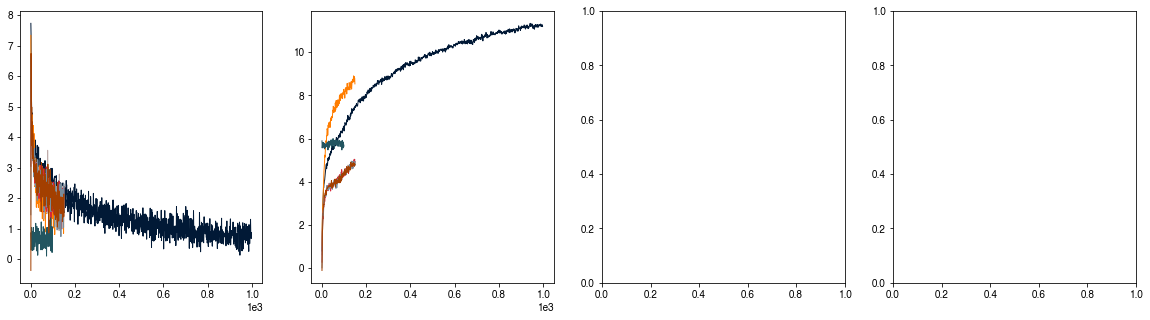

In [20]:
odd_data = ['NCAR_CESM2_r1i1p1f1','E3SM-Project_E3SM-1-0_r1i1p1f1','NASA-GISS_GISS-E2-1-G_r1i1p1f3'] + ['MRI_MRI-ESM2-0_r'+str(x)+'i1p1f1' for x in [4,7,10,13]]

fig,ax = plt.subplots(1,4,figsize=(20,5))

for odd in odd_data:
    ax[0].plot(abrupt4x_EB_anom_df[odd].dropna().values,lw=1,label=odd)
    ax[1].plot(abrupt4x_tas_anom_df[odd].dropna().values,lw=1,label=odd)
#     ax[2].plot(onepct_EB_anom_df[odd].dropna().values,lw=1,label=odd)
#     ax[3].plot(onepct_tas_anom_df[odd].dropna().values,lw=1,label=odd)
    
## these MRI realisations appear to have one year of piControl data at the start (ie. before the forcing increase) -> write a catch

#### Create the required definitions

In [21]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt):
    
    # computes a Kalman filter recursively over all the timesteps of the input data, yt
    # returns the Negative log likelihood for fitting
    
    n = yt.shape[1] # measurements
    k = a0.shape[0] # state dimension size
    d = yt.shape[0] # measurement dimensions
    vt = np.zeros((d,n))
    Ft = np.zeros((d,d,n))
    Kt = np.zeros((k,d,n))
    at = np.zeros((k,n+1))
    Pt = np.zeros((k,k,n+1))
    nll = 0

    at[...,0] = a0
    Pt[...,0] = P0

    for i in np.arange(n):
        vt[...,i] = yt[...,i] - ct - Zt @ at[...,i]
        Ft[...,i] = Zt @ Pt[...,i] @ Zt.T + GGt
        Kt[...,i] = Pt[...,i] @ Zt.T @ np.linalg.inv(Ft[...,i])
        att = at[...,i] + Kt[...,i] @ vt[...,i]
        Ptt = Pt[...,i] - Pt[...,i] @ Zt.T @ Kt[...,i].T

        at[...,i+1] = dt[...,i] + Tt@att
        Pt[...,i+1] = Tt @ Ptt @ Tt.T + HHt
        
        nll += np.log(2*np.pi) + (1/2) * (  np.log(np.linalg.det(Ft[...,i])) + vt[...,i].T @ np.linalg.inv(Ft[...,i]) @ vt[...,i] )
        
    return nll

In [22]:
def nll_abrupt4x(par,yt,transform=True):
    
    if transform:
        par = np.exp(par)
    
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(par)
    k = A.shape[0]
    u = np.full(yt.shape[-1],par[-1]).reshape(1,-1)
    
    gamma0 = (sp.linalg.solve(np.identity(k**2)-np.kron(A_d,A_d),Q_d.flatten())).reshape(4,4)
    x0 = np.array([par[-1],0,0,0])
    a0 = A_d@x0 + b_d*u[...,0]
    
    P0 = gamma0.copy()
    dt = (b_d.reshape(-1,1)@u)
    ct = np.zeros(2)
    Tt = A_d.copy()
    Zt = C_d.copy()
    HHt = Q_d.copy()
    GGt = np.identity(2)*1e-15
    
    return Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt)

In [23]:
def nll_onepct(par,yt,co2,transform=True):
    
    if transform:
        par = np.exp(par)
        
    conc0 = co2[0]/1.01
    sqrt_coef = (par[-1]-2*par[-2]) / (np.sqrt(conc0) * (3-2*np.sqrt(2)) )
    log_coef = ( par[-2] - sqrt_coef * (np.sqrt(2*conc0)-np.sqrt(conc0)) ) / np.log(2)
    
    u = ( log_coef*np.log(co2/conc0) + sqrt_coef*( np.sqrt(co2) - np.sqrt(conc0) ) ).reshape(1,-1)
    
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(par)
    k = A.shape[0]
    
    gamma0 = (sp.linalg.solve(np.identity(k**2)-np.kron(A_d,A_d),Q_d.flatten())).reshape(4,4)
    x0 = np.array([u[0,0],0,0,0])
    a0 = A_d@x0 + b_d*u[...,0]
    
    P0 = gamma0.copy()
    dt = (b_d.reshape(-1,1)@u)
    ct = np.zeros(2)
    Tt = A_d.copy()
    Zt = C_d.copy()
    HHt = Q_d.copy()
    GGt = np.identity(2)*1e-15
    
    return Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt)

In [24]:
def visual_check_abrupt4x(ism,fit_params):

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    CMIP6_run = abrupt4x_tas_anom_df[ism].dropna().values
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)
    
    w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)
    
    x = np.zeros((CMIP6_run.shape[0]+1,4))
    y = np.zeros((CMIP6_run.shape[0]+1,2))
    
    x[:,0] = fit_params[-1]
    y[0,:] = C_d @ x[0]
    
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*fit_params[-1]
        y[t+1] = C_d@x[t+1]
    
    ax[0].plot(np.arange(CMIP6_run.shape[0]),y[1:,0],ls='--')
    ax[0].plot(np.arange(CMIP6_run.shape[0]),CMIP6_run)
    ax[1].plot(np.arange(CMIP6_run.shape[0]),y[1:,1],ls='--')
    ax[1].plot(np.arange(CMIP6_run.shape[0]),abrupt4x_EB_anom_df[ism].dropna().values,label=ism)
    ax[2].plot(y[1:,0],y[1:,1],ls='--')
    ax[2].plot(CMIP6_run,abrupt4x_EB_anom_df[ism].dropna().values,'o',ms=1,zorder=0)
    
    ax[0].set_title('tas')
    ax[1].set_title('TOA EB')
    ax[2].set_title('tas / TOA EB')
    
    fig.suptitle(ism+' verification',fontweight='bold')
    
    return y

def visual_check_onepct(ism,fit_params):

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    CMIP6_run = onepct_tas_anom_df[ism].dropna().values
    CMIP6_co2 = 284 * 1.01**np.arange(1,CMIP6_run.shape[0]+1)
    
    conc0 = CMIP6_co2[0]/1.01
    sqrt_coef = (fit_params[-1]-2*fit_params[-2]) / (np.sqrt(conc0) * (3-2*np.sqrt(2)) )
    log_coef = ( fit_params[-2] - sqrt_coef * (np.sqrt(2*conc0)-np.sqrt(conc0)) ) / np.log(2)
    
    u = ( log_coef*np.log(CMIP6_co2/conc0) + sqrt_coef*( np.sqrt(CMIP6_co2) - np.sqrt(conc0) ) ).reshape(1,-1)
    
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)
    
    w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)
    
    x = np.zeros((CMIP6_run.shape[0]+1,4))
    y = np.zeros((CMIP6_run.shape[0]+1,2))
    
    x[:,0] = u[0,0]
    y[0,:] = C_d @ x[0]
    
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*u[...,t]
        y[t+1] = C_d@x[t+1]
    
    ax[0].plot(np.arange(CMIP6_run.shape[0]),y[1:,0],ls='--')
    ax[0].plot(np.arange(CMIP6_run.shape[0]),CMIP6_run)
    ax[1].plot(np.arange(CMIP6_run.shape[0]),y[1:,1],ls='--')
    ax[1].plot(np.arange(CMIP6_run.shape[0]),onepct_EB_anom_df[ism].dropna().values,label=ism)
    ax[2].plot(y[1:,0],y[1:,1],ls='--')
    ax[2].plot(CMIP6_run,onepct_EB_anom_df[ism].dropna().values)
    
    ax[0].set_title('tas')
    ax[1].set_title('TOA EB')
    ax[2].set_title('tas / TOA EB')
    
    fig.suptitle(ism+' verification',fontweight='bold')
    
    return y

In [25]:
def fit_ism(ism,plot_output=False):
    
    print('getting data for '+ism)
    
    abrupt4x_yt = np.array([abrupt4x_tas_anom_df[ism].dropna().values,abrupt4x_EB_anom_df[ism].dropna().values])
#     onepct_yt = np.array([onepct_tas_anom_df[ism].dropna().values,onepct_EB_anom_df[ism].dropna().values])
#     onepct_co2 = 284 * 1.01**np.arange(1,onepct_yt.shape[1]+1)
    # param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']
    
    if abrupt4x_yt.shape[-1]<50:
        print('insufficient data')
        return None
    
    if ism in ['MRI_MRI-ESM2-0_r'+str(x)+'i1p1f1' for x in [4,7,10,13]]:
        abrupt4x_yt = abrupt4x_yt[...,1:] # remove the year of piControl from the data
    
    par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

    print('fitting '+ism)
    
    fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),options={'maxfev':20000})
    
    if fit_params.success==1:
        print(ism+' fit converged')
        
        if plot_output:
            visual_check_abrupt4x(ism,np.exp(fit_params.x))
            plt.show()
#         visual_check_onepct(ism,np.exp(fit_params.x))

        return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(ism)
    
    else:
        print('trying BOBYQA')
        fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})
        
        if fit_params.success==1:
            print(ism+' fit converged with BOBYQA')
        
            if plot_output:
                visual_check_abrupt4x(ism,np.exp(fit_params.x))
                plt.show()
    #         visual_check_onepct(ism,np.exp(fit_params.x))

            return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(ism)
    
        else:
        
            print(ism+' fit failed')
            return None

getting data for IPSL_IPSL-CM6A-LR_r3i1p1f1
insufficient data
getting data for CCCma_CanESM5_r1i1p1f1
fitting CCCma_CanESM5_r1i1p1f1
CCCma_CanESM5_r1i1p1f1 fit converged


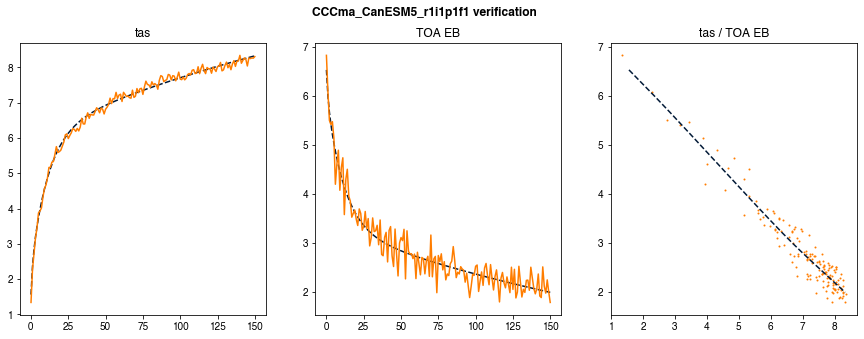

getting data for CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
insufficient data
getting data for CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
fitting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2 fit converged


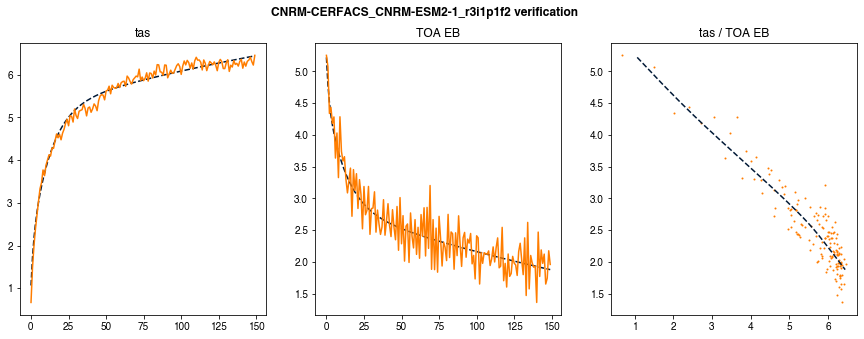

getting data for CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
fitting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1 fit converged


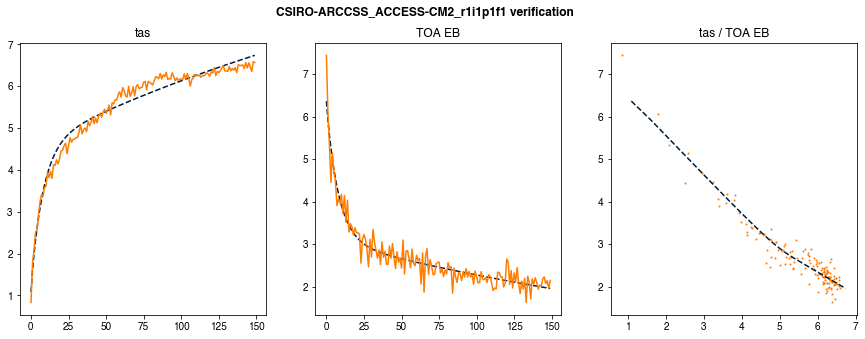

getting data for CAMS_CAMS-CSM1-0_r1i1p1f1
fitting CAMS_CAMS-CSM1-0_r1i1p1f1
CAMS_CAMS-CSM1-0_r1i1p1f1 fit converged


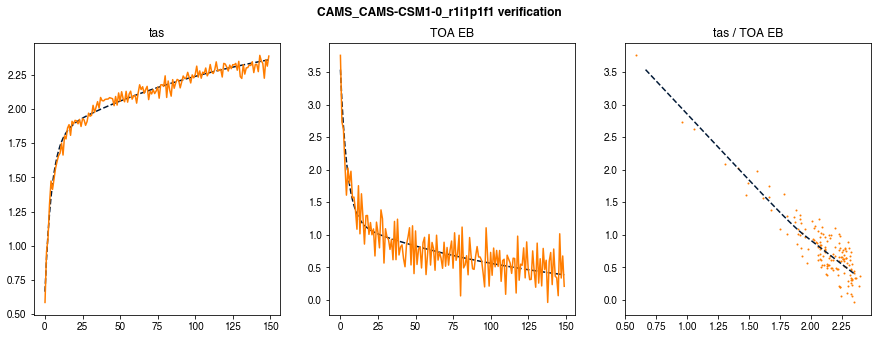

getting data for IPSL_IPSL-CM6A-LR_r2i1p1f1
insufficient data
getting data for IPSL_IPSL-CM6A-LR_r6i1p1f1
insufficient data
getting data for IPSL_IPSL-CM6A-LR_r9i1p1f1
insufficient data
getting data for NASA-GISS_GISS-E2-1-G_r1i1p1f3
fitting NASA-GISS_GISS-E2-1-G_r1i1p1f3
trying BOBYQA
NASA-GISS_GISS-E2-1-G_r1i1p1f3 fit failed
getting data for NOAA-GFDL_GFDL-ESM4_r1i1p1f1
fitting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
NOAA-GFDL_GFDL-ESM4_r1i1p1f1 fit converged


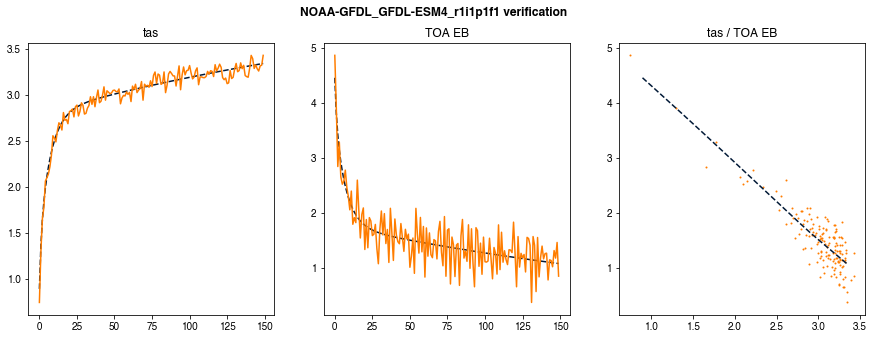

getting data for MRI_MRI-ESM2-0_r11i1p1f1
insufficient data
getting data for MRI_MRI-ESM2-0_r3i1p1f1
insufficient data
getting data for CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
insufficient data
getting data for MPI-M_MPI-ESM1-2-HR_r1i1p1f1
fitting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
MPI-M_MPI-ESM1-2-HR_r1i1p1f1 fit converged


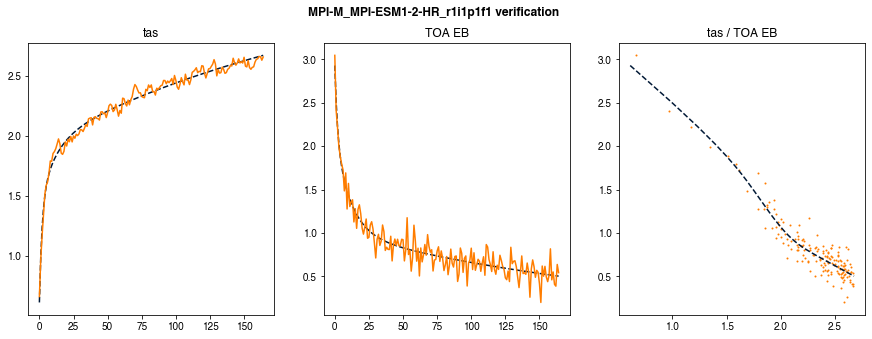

getting data for MRI_MRI-ESM2-0_r6i1p1f1
insufficient data
getting data for E3SM-Project_E3SM-1-0_r1i1p1f1
fitting E3SM-Project_E3SM-1-0_r1i1p1f1
E3SM-Project_E3SM-1-0_r1i1p1f1 fit converged


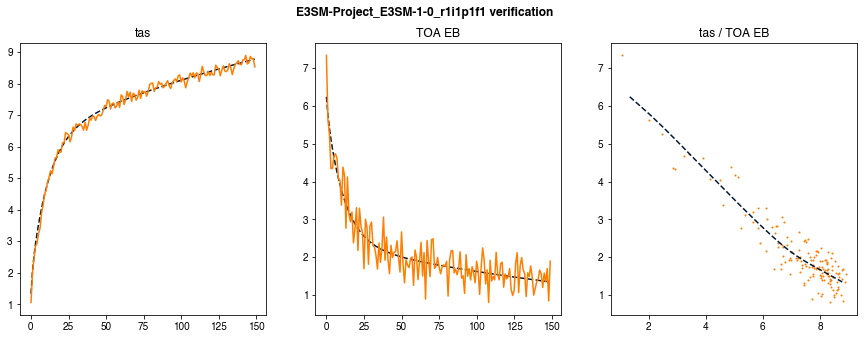

getting data for IPSL_IPSL-CM6A-LR_r10i1p1f1
insufficient data
getting data for MRI_MRI-ESM2-0_r1i2p1f1
fitting MRI_MRI-ESM2-0_r1i2p1f1
MRI_MRI-ESM2-0_r1i2p1f1 fit converged


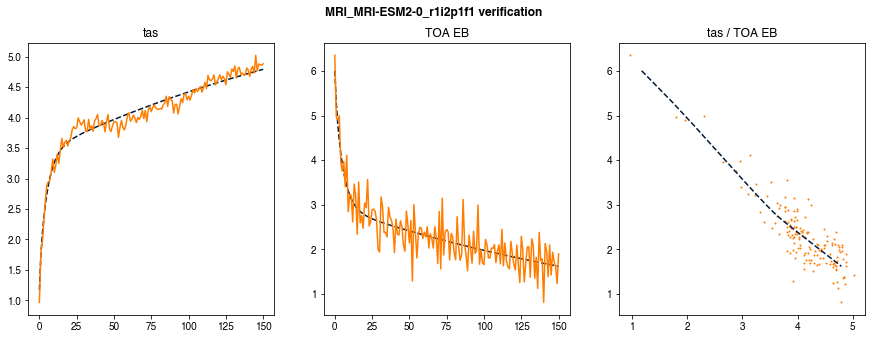

getting data for MRI_MRI-ESM2-0_r12i1p1f1
insufficient data
getting data for CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2
fitting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2
CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2 fit converged


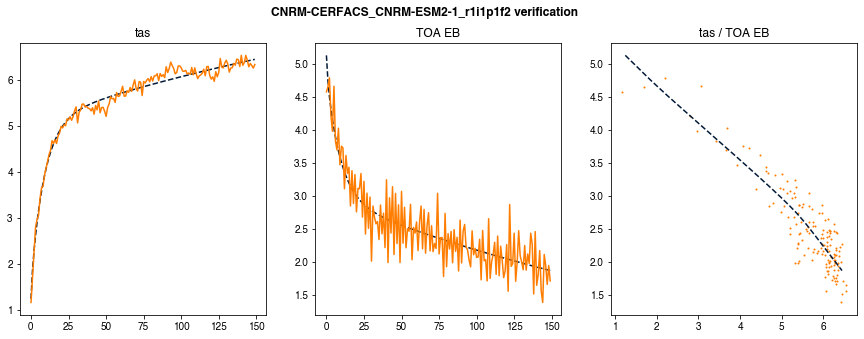

getting data for CCCma_CanESM5_r1i1p2f1
fitting CCCma_CanESM5_r1i1p2f1
CCCma_CanESM5_r1i1p2f1 fit converged


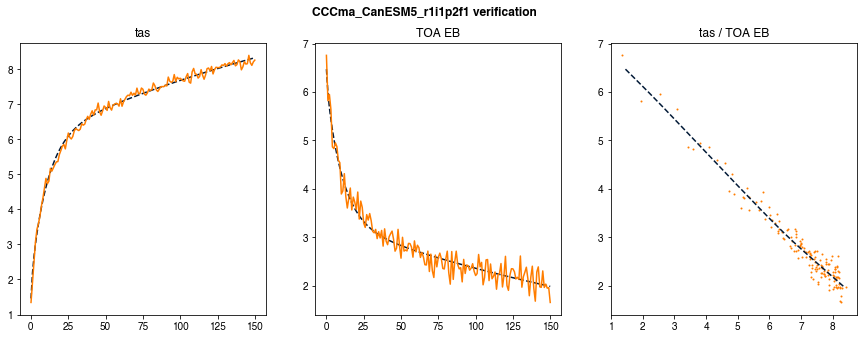

getting data for IPSL_IPSL-CM6A-LR_r1i1p1f1
fitting IPSL_IPSL-CM6A-LR_r1i1p1f1
IPSL_IPSL-CM6A-LR_r1i1p1f1 fit converged


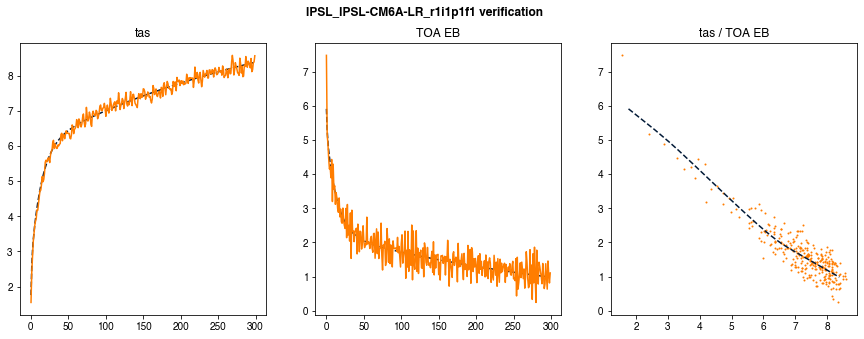

getting data for MIROC_MIROC-ES2L_r1i1p1f2
fitting MIROC_MIROC-ES2L_r1i1p1f2
trying BOBYQA
MIROC_MIROC-ES2L_r1i1p1f2 fit failed
getting data for NOAA-GFDL_GFDL-CM4_r1i1p1f1
fitting NOAA-GFDL_GFDL-CM4_r1i1p1f1
NOAA-GFDL_GFDL-CM4_r1i1p1f1 fit converged


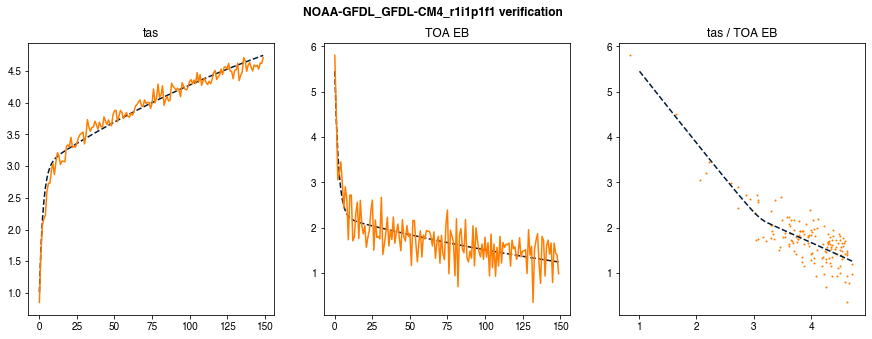

getting data for INM_INM-CM5-0_r1i1p1f1
fitting INM_INM-CM5-0_r1i1p1f1
INM_INM-CM5-0_r1i1p1f1 fit converged


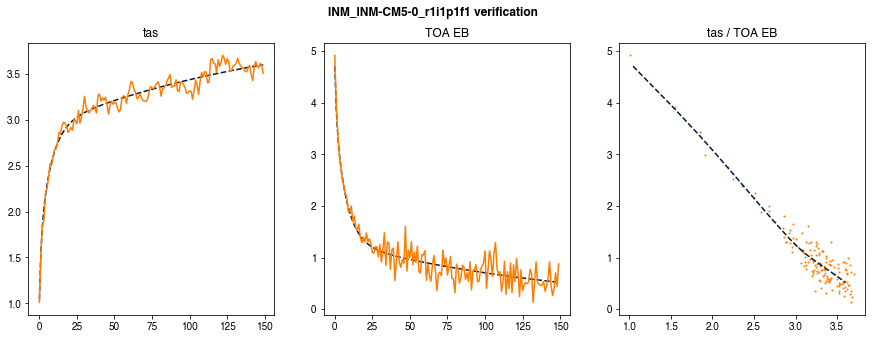

getting data for IPSL_IPSL-CM6A-LR_r5i1p1f1
insufficient data
getting data for CSIRO_ACCESS-ESM1-5_r1i1p1f1
fitting CSIRO_ACCESS-ESM1-5_r1i1p1f1
CSIRO_ACCESS-ESM1-5_r1i1p1f1 fit converged


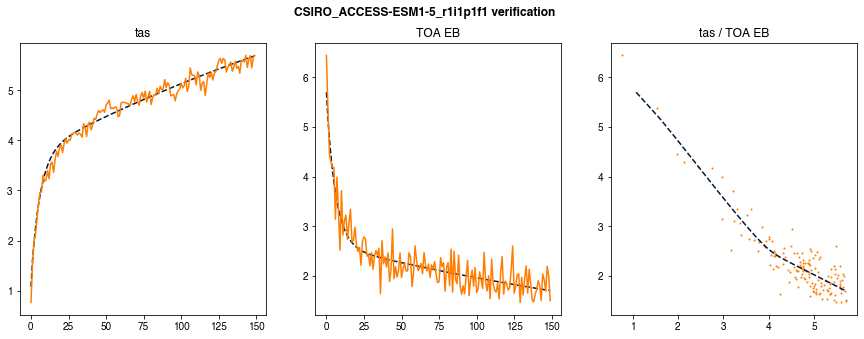

getting data for MIROC_MIROC6_r1i1p1f1
fitting MIROC_MIROC6_r1i1p1f1
MIROC_MIROC6_r1i1p1f1 fit converged


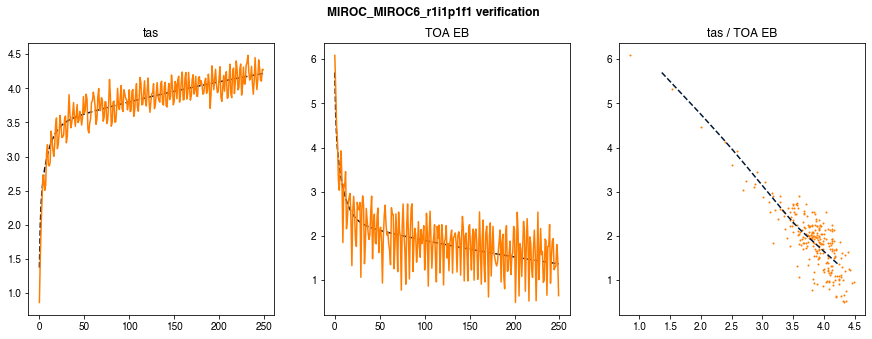

getting data for MRI_MRI-ESM2-0_r13i1p1f1
fitting MRI_MRI-ESM2-0_r13i1p1f1
MRI_MRI-ESM2-0_r13i1p1f1 fit converged


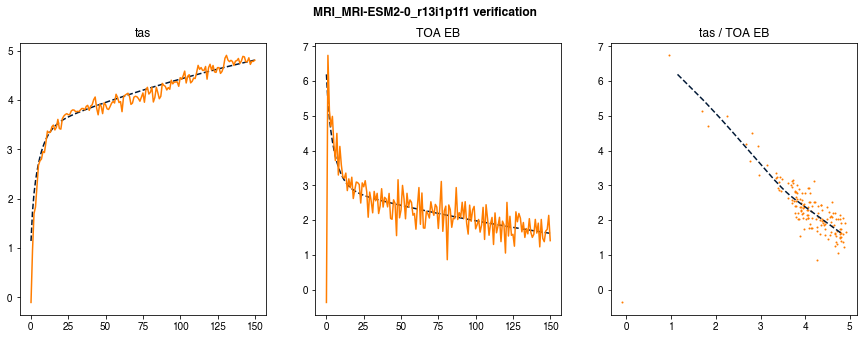

getting data for MRI_MRI-ESM2-0_r10i1p1f1
fitting MRI_MRI-ESM2-0_r10i1p1f1
MRI_MRI-ESM2-0_r10i1p1f1 fit converged


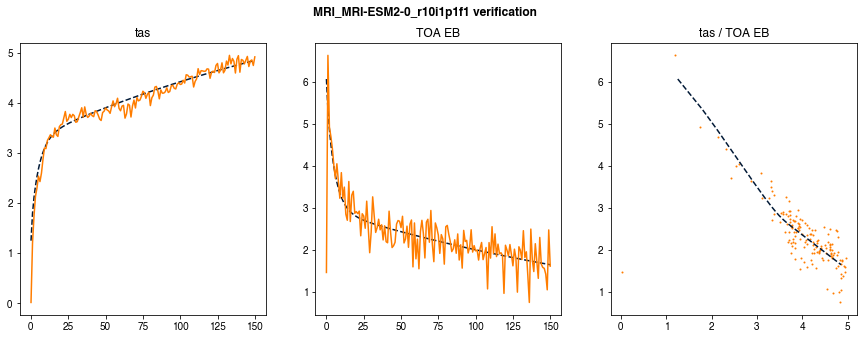

getting data for NCAR_CESM2_r1i1p1f1
fitting NCAR_CESM2_r1i1p1f1
NCAR_CESM2_r1i1p1f1 fit converged


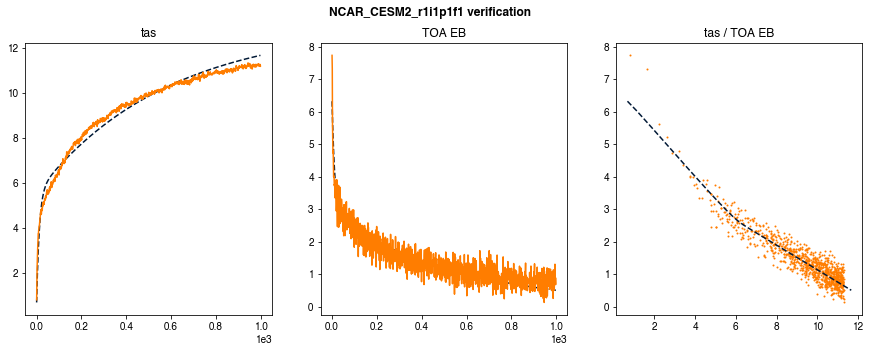

getting data for CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
insufficient data
getting data for MRI_MRI-ESM2-0_r1i1p1f1
fitting MRI_MRI-ESM2-0_r1i1p1f1
MRI_MRI-ESM2-0_r1i1p1f1 fit converged


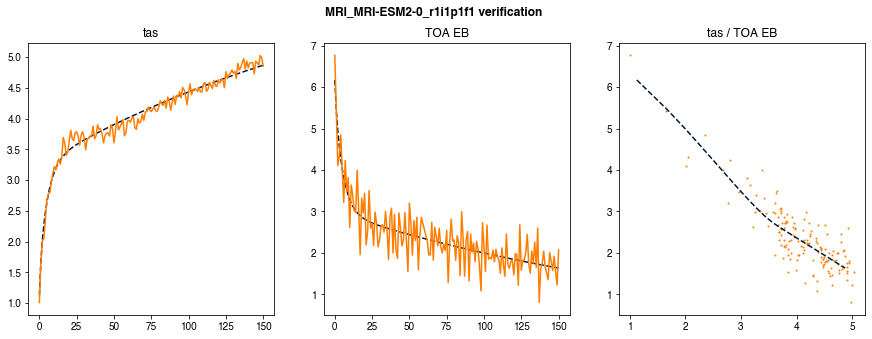

getting data for MPI-M_MPI-ESM1-2-LR_r1i1p1f1
fitting MPI-M_MPI-ESM1-2-LR_r1i1p1f1
MPI-M_MPI-ESM1-2-LR_r1i1p1f1 fit converged


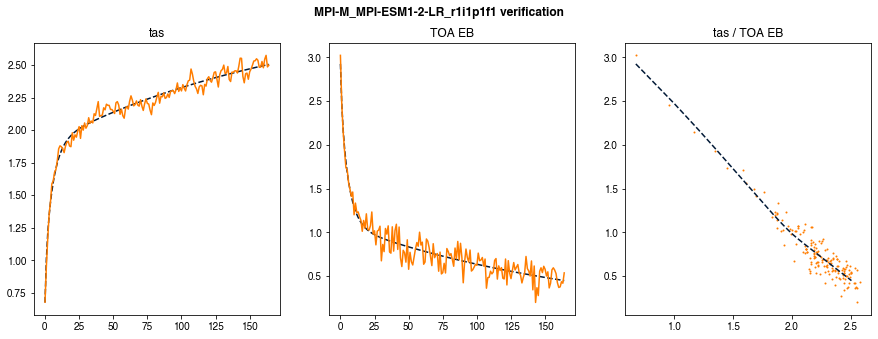

getting data for NASA-GISS_GISS-E2-1-H_r1i1p1f1
fitting NASA-GISS_GISS-E2-1-H_r1i1p1f1
NASA-GISS_GISS-E2-1-H_r1i1p1f1 fit converged


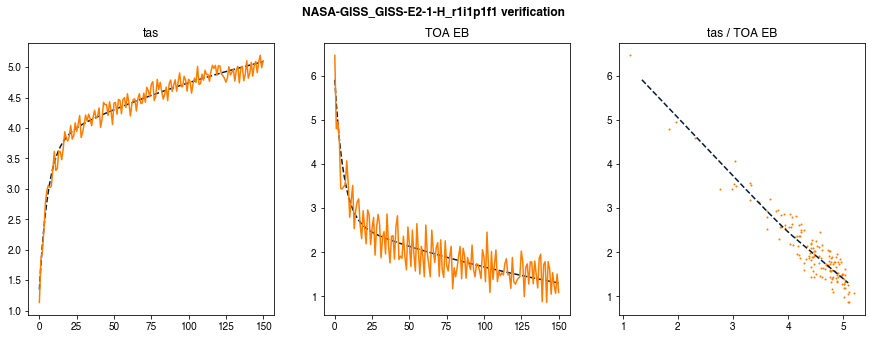

getting data for CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
fitting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2 fit converged


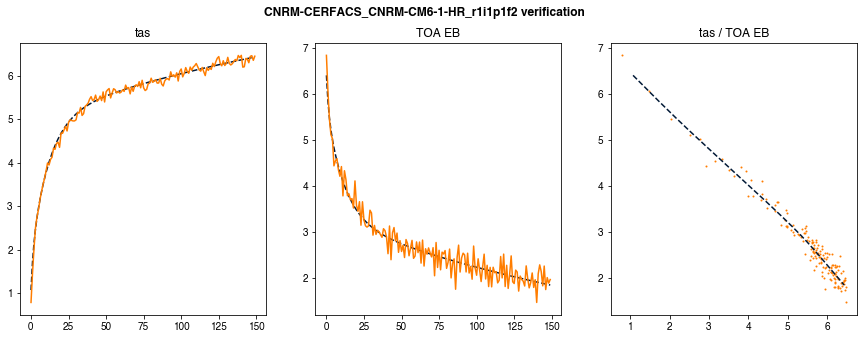

getting data for MOHC_HadGEM3-GC31-LL_r1i1p1f3
fitting MOHC_HadGEM3-GC31-LL_r1i1p1f3
MOHC_HadGEM3-GC31-LL_r1i1p1f3 fit converged


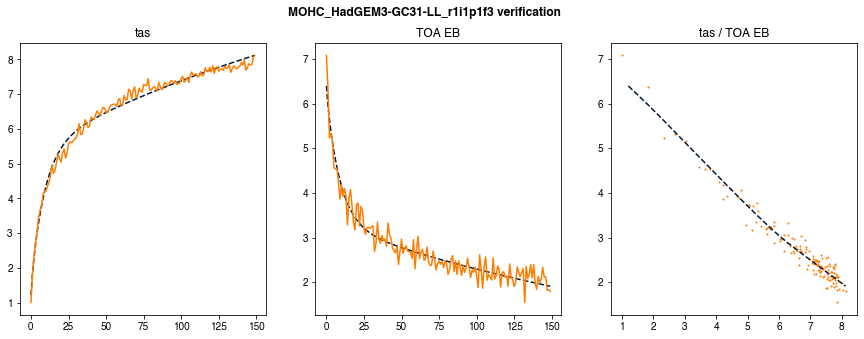

getting data for NCC_NorESM2-LM_r1i1p1f1
fitting NCC_NorESM2-LM_r1i1p1f1
trying BOBYQA
NCC_NorESM2-LM_r1i1p1f1 fit failed
getting data for MRI_MRI-ESM2-0_r4i1p1f1
fitting MRI_MRI-ESM2-0_r4i1p1f1
MRI_MRI-ESM2-0_r4i1p1f1 fit converged


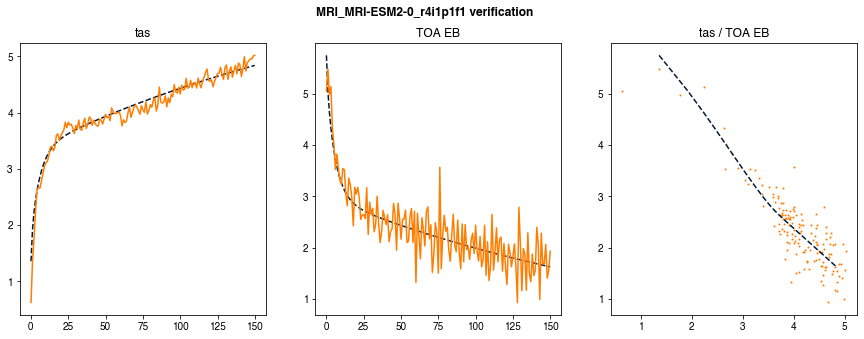

getting data for IPSL_IPSL-CM6A-LR_r12i1p1f1
insufficient data
getting data for MOHC_HadGEM3-GC31-MM_r1i1p1f3
fitting MOHC_HadGEM3-GC31-MM_r1i1p1f3
trying BOBYQA
MOHC_HadGEM3-GC31-MM_r1i1p1f3 fit converged with BOBYQA


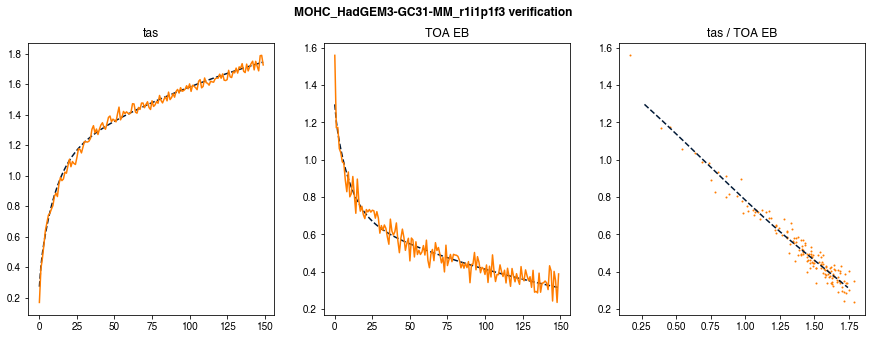

getting data for BCC_BCC-ESM1_r1i1p1f1
fitting BCC_BCC-ESM1_r1i1p1f1
BCC_BCC-ESM1_r1i1p1f1 fit converged


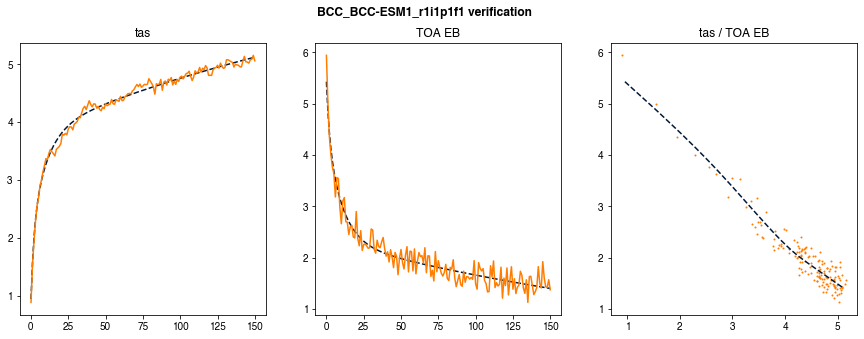

getting data for CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2
insufficient data
getting data for IPSL_IPSL-CM6A-LR_r7i1p1f1
insufficient data
getting data for MRI_MRI-ESM2-0_r2i1p1f1
insufficient data
getting data for NCC_NorCPM1_r1i1p1f1
fitting NCC_NorCPM1_r1i1p1f1
NCC_NorCPM1_r1i1p1f1 fit converged


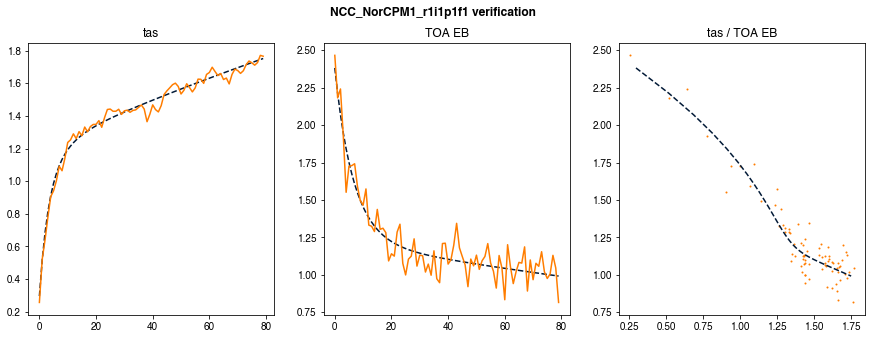

getting data for NCC_NorESM2-MM_r1i1p1f1
fitting NCC_NorESM2-MM_r1i1p1f1
trying BOBYQA
NCC_NorESM2-MM_r1i1p1f1 fit failed
getting data for CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2
fitting CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2
CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2 fit converged


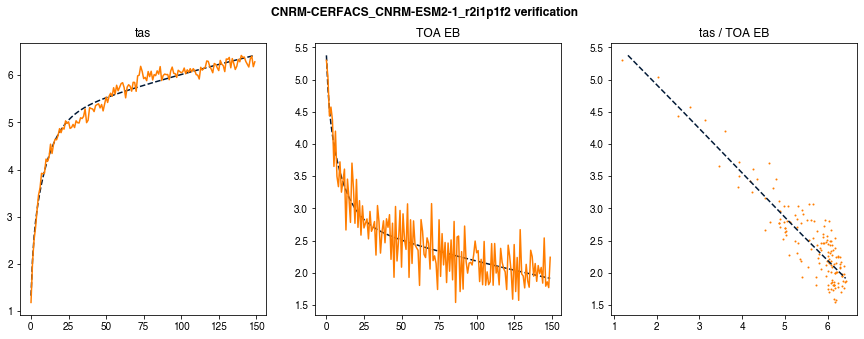

getting data for IPSL_IPSL-CM6A-LR_r4i1p1f1
insufficient data
getting data for NCAR_CESM2-WACCM_r1i1p1f1
fitting NCAR_CESM2-WACCM_r1i1p1f1
NCAR_CESM2-WACCM_r1i1p1f1 fit converged


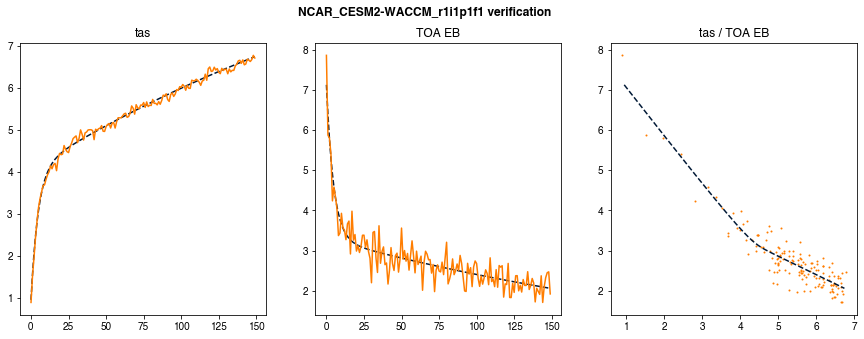

getting data for IPSL_IPSL-CM6A-LR_r11i1p1f1
insufficient data
getting data for MRI_MRI-ESM2-0_r5i1p1f1
insufficient data
getting data for MRI_MRI-ESM2-0_r7i1p1f1
fitting MRI_MRI-ESM2-0_r7i1p1f1
MRI_MRI-ESM2-0_r7i1p1f1 fit converged


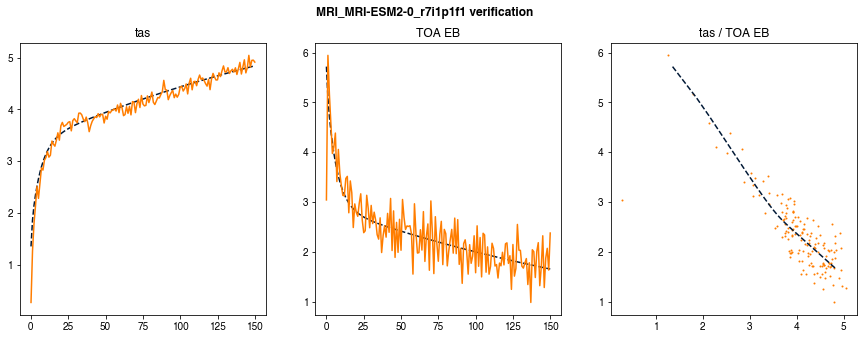

getting data for SNU_SAM0-UNICON_r1i1p1f1
fitting SNU_SAM0-UNICON_r1i1p1f1
SNU_SAM0-UNICON_r1i1p1f1 fit converged


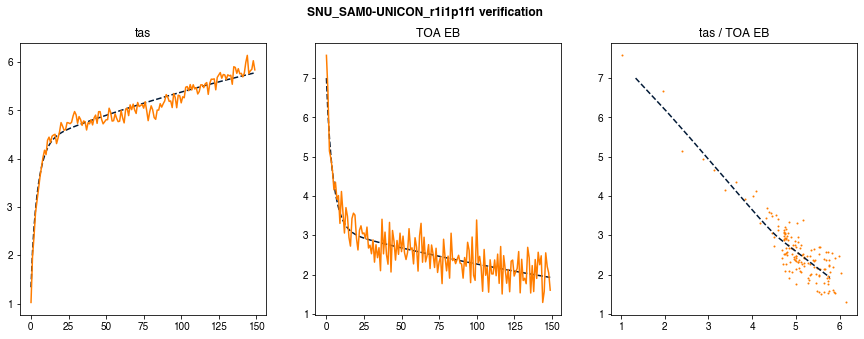

getting data for NASA-GISS_GISS-E2-1-G_r1i1p5f1
fitting NASA-GISS_GISS-E2-1-G_r1i1p5f1
NASA-GISS_GISS-E2-1-G_r1i1p5f1 fit converged


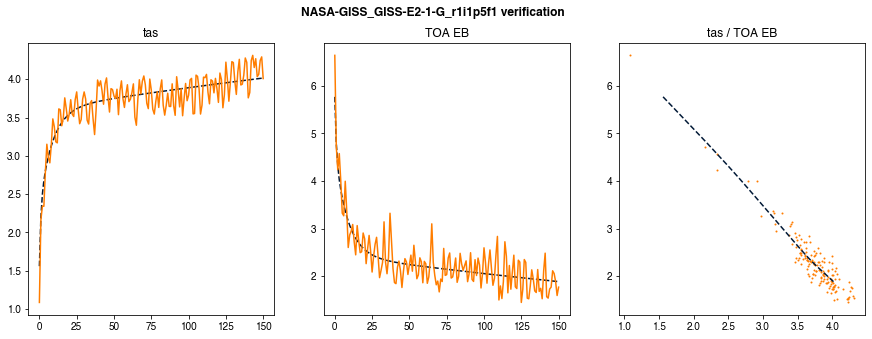

getting data for MOHC_UKESM1-0-LL_r1i1p1f2
fitting MOHC_UKESM1-0-LL_r1i1p1f2
MOHC_UKESM1-0-LL_r1i1p1f2 fit converged


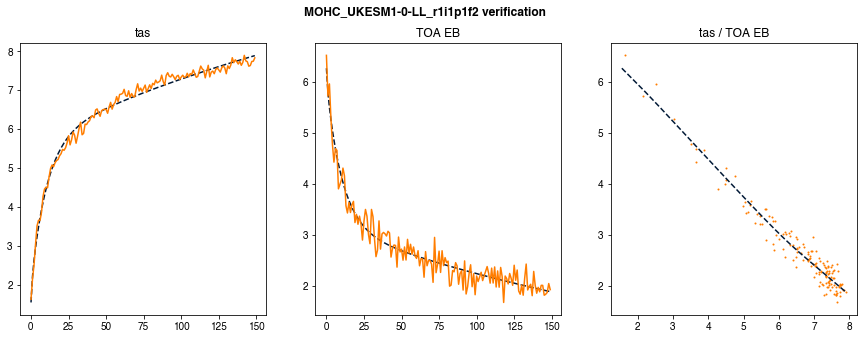

getting data for NASA-GISS_GISS-E2-1-G_r102i1p1f1
fitting NASA-GISS_GISS-E2-1-G_r102i1p1f1
NASA-GISS_GISS-E2-1-G_r102i1p1f1 fit converged


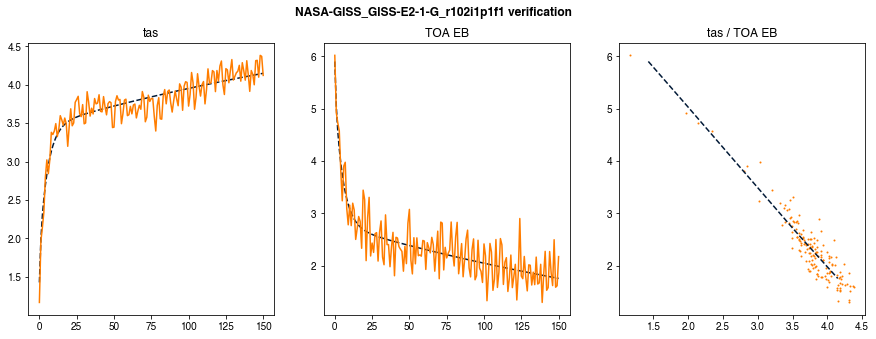

getting data for CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
fitting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2 fit converged


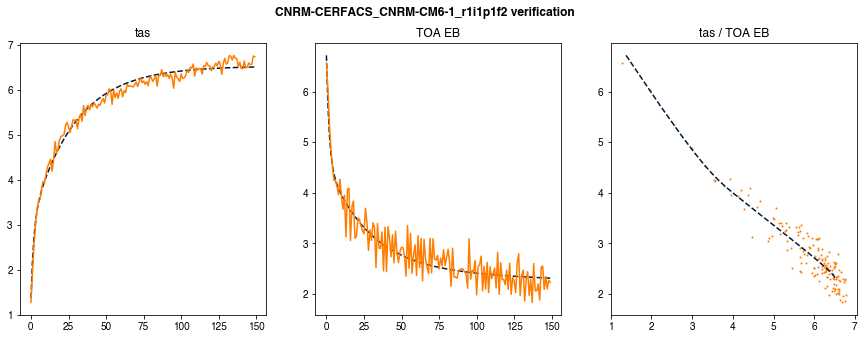

getting data for NASA-GISS_GISS-E2-1-G_r1i1p3f1
fitting NASA-GISS_GISS-E2-1-G_r1i1p3f1
NASA-GISS_GISS-E2-1-G_r1i1p3f1 fit converged


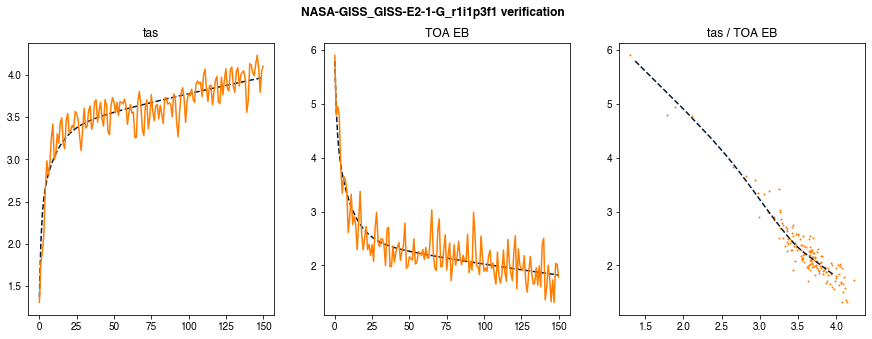

getting data for IPSL_IPSL-CM6A-LR_r8i1p1f1
insufficient data
getting data for CNRM-CERFACS_CNRM-CM6-1_r4i1p1f2
insufficient data
getting data for MRI_MRI-ESM2-0_r9i1p1f1
insufficient data
getting data for NASA-GISS_GISS-E2-1-G_r1i1p1f1
fitting NASA-GISS_GISS-E2-1-G_r1i1p1f1
NASA-GISS_GISS-E2-1-G_r1i1p1f1 fit converged


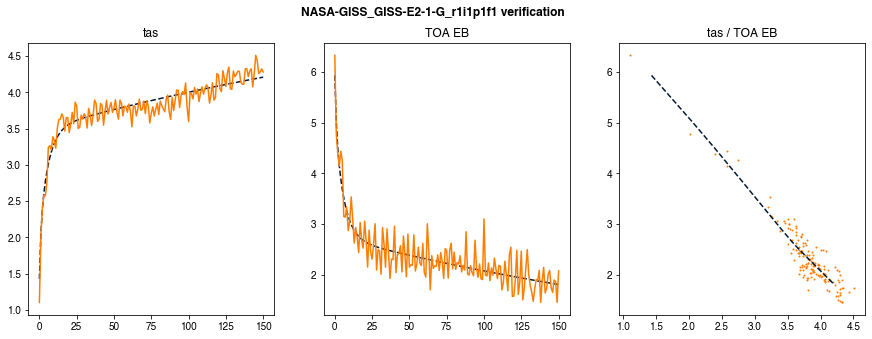

getting data for MRI_MRI-ESM2-0_r8i1p1f1
insufficient data
getting data for INM_INM-CM4-8_r1i1p1f1
fitting INM_INM-CM4-8_r1i1p1f1
INM_INM-CM4-8_r1i1p1f1 fit converged


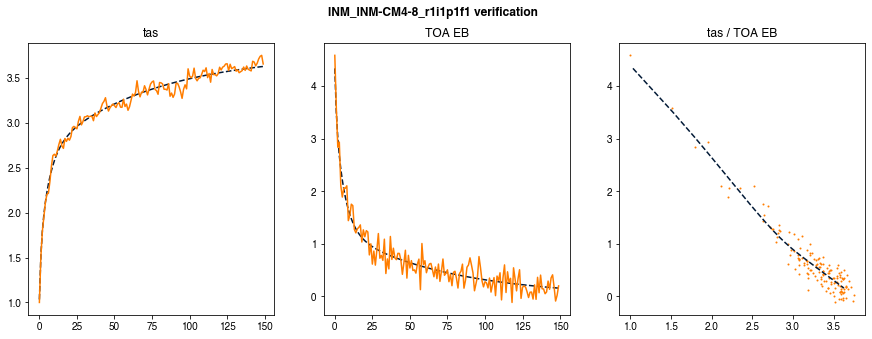

getting data for CAMS_CAMS-CSM1-0_r2i1p1f1
fitting CAMS_CAMS-CSM1-0_r2i1p1f1
CAMS_CAMS-CSM1-0_r2i1p1f1 fit converged


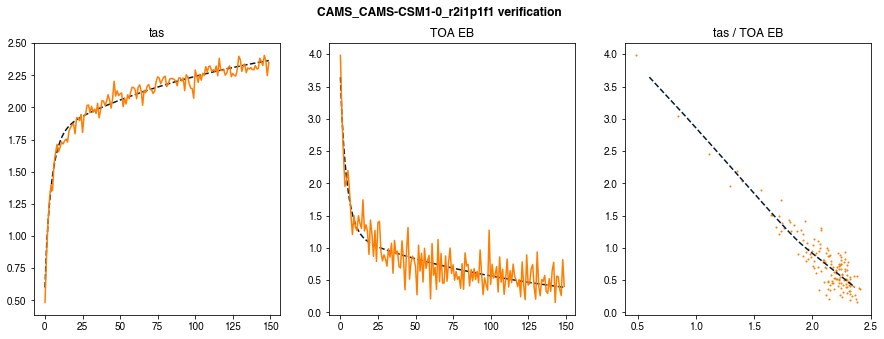

In [26]:
result_abrupt4x = []
for ism in abrupt4x_tas_anom_df.columns:
    result_abrupt4x += [fit_ism(ism,True)]

fitting NCAR_CESM2_r1i1p1f1
NCAR_CESM2_r1i1p1f1 fit converged


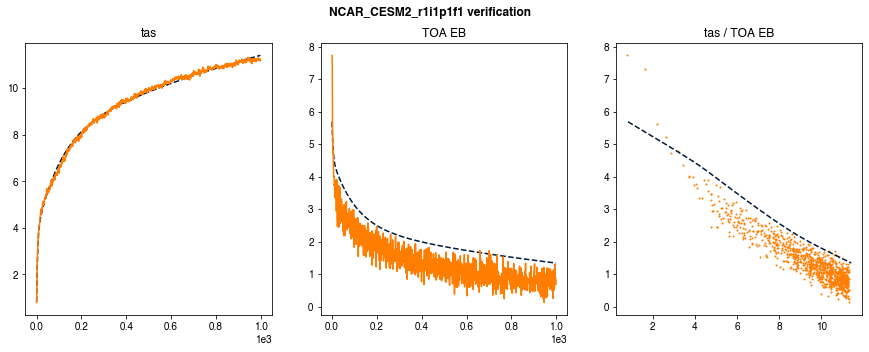

In [187]:
## redo fitting to CESM2 (biased from the length of the run)
ism = 'NCAR_CESM2_r1i1p1f1'

# abrupt4x_yt = np.array([abrupt4x_tas_anom_df[ism].dropna().values,\
#                         (abrupt4x_rsdt_df-abrupt4x_rsut_df-abrupt4x_rlut_df)[ism].dropna().values])

abrupt4x_yt = np.array([abrupt4x_tas_anom_df[ism].dropna().values,\
                        (abrupt4x_rsdt_df-abrupt4x_rsut_df-abrupt4x_rlut_df)[ism].dropna().values]) # looks like the TOA energy balance wants to go to zero...
    
par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 9])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+ism)

lb = np.array([0,0,0,0,0.3,0,0,0,0,0,8.8])
ub=np.array([np.inf,np.inf,np.inf,np.inf,3,np.inf,4,3,2,1.1,11])
bounds=Bounds(lb,ub)
fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True),np.log(par0),options={'maxfev':20000})

if fit_params.success==1:
    print(ism+' fit converged')

CESM2_yt = visual_check_abrupt4x(ism,np.exp(fit_params.x))

In [201]:
res_df = pd.concat(result_abrupt4x,axis=1)
# res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

## if alternate CESM2 fit to be used:
res_df.loc[:,'NCAR_CESM2_r1i1p1f1'] = np.exp(fit_params.x)

In [202]:
## write a function to compute the F2x scaling:

def fit_F2x(x,ism):
    
    fit_params = res_df[ism].values

    tas_data = onepct_tas_anom_df[ism].dropna().values
    EB_data = onepct_EB_anom_df[ism].dropna().values
    y_data = np.array([tas_data,EB_data])
    
    if ism in ['NASA-GISS_GISS-E2-1-G_r1i1p1f1','NASA-GISS_GISS-E2-1-G_r102i1p1f1']:
        y_data=y_data[...,:70]
    
    co2 = 284 * 1.01**np.arange(1,y_data.shape[1]+1)

    conc0 = 284
    
    sqrt_coef = (fit_params[10]-2*x) / (np.sqrt(conc0) * (3-2*np.sqrt(2)) )
    log_coef = ( x - sqrt_coef * (np.sqrt(2*conc0)-np.sqrt(conc0)) ) / np.log(2)
    
    u = ( log_coef*np.log(co2/conc0) + sqrt_coef*( np.sqrt(co2) - np.sqrt(conc0) ) ).reshape(1,-1)

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)

    w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)

    x = np.zeros((y_data.shape[1]+1,4))
    y = np.zeros((y_data.shape[1]+1,2))

    x[:,0] = u[0,0]
    y[0,:] = C_d @ x[0]

    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*u[...,t]
        y[t+1] = C_d@x[t+1]
        
    tas_diff = y[1:,0].T - y_data[0,:]
    EB_diff = y[1:,1].T - y_data[1,:]
    
    tas_diff_rel = (y[1:,0] - y[1:50,0].mean()).T - (y_data[0,:] - y_data[0,:49].mean())
    EB_diff_rel = (y[1:,1] - y[1:50,1].mean()).T - (y_data[1,:] - y_data[1,:49].mean())
        
    return np.sum(np.abs(tas_diff_rel))#np.sum(np.abs((y[1:] - y[1:10].mean(axis=0)[np.newaxis,:]).T - (y_data - y_data[...,:10].mean(axis=1)[:,np.newaxis]))) # to try and account for internal var at the start, remove the mean of the first 10 years

In [203]:
res_df.loc['F_2x'] = np.nan

for ism in set(res_df.columns).intersection(set(onepct_tas_anom_df.columns)):
    result_F2x = sp.optimize.minimize(lambda x: fit_F2x(x,ism) , x0 = res_df.loc['F_4x',ism]/2,method='nelder-mead')
    if result_F2x.success:
        res_df.loc['F_2x',ism] = result_F2x.x

In [204]:
def check_F2x(ism):
    
    fit_params = res_df[ism].values

    if ism in onepct_tas_anom_df.columns:
        tas_data = onepct_tas_anom_df[ism].dropna().values
        EB_data = onepct_EB_anom_df[ism].dropna().values
        y_data = np.array([tas_data,EB_data])
        run_length = y_data.shape[1]
    else:
        y_data = None
        run_length = 150
    
    co2 = 284 * 1.01**np.arange(1,run_length+1)

    conc0 = 284
    
    if np.isnan(fit_params[11]):
        log_coef = fit_params[10]/np.log(4)
        sqrt_coef=0
    else:
        sqrt_coef = (fit_params[10]-2*fit_params[11]) / (np.sqrt(conc0) * (3-2*np.sqrt(2)) )
        log_coef = ( fit_params[11] - sqrt_coef * (np.sqrt(2*conc0)-np.sqrt(conc0)) ) / np.log(2)
    
    u = ( log_coef*np.log(co2/conc0) + sqrt_coef*( np.sqrt(co2) - np.sqrt(conc0) ) ).reshape(1,-1)

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)

    w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)

    x = np.zeros((run_length+1,4))
    y = np.zeros((run_length+1,2))

    x[:,0] = u[0,0]
    y[0,:] = C_d @ x[0]

    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*u[...,t]
        y[t+1] = C_d@x[t+1]
        
    return y.T,y_data

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


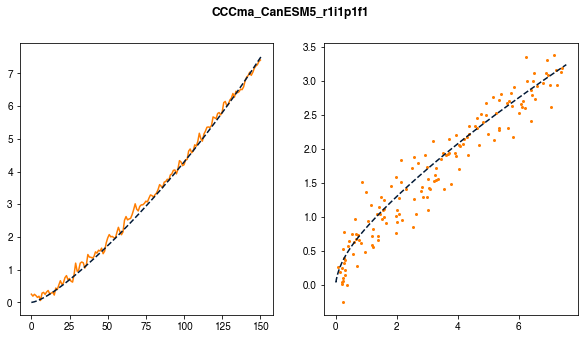

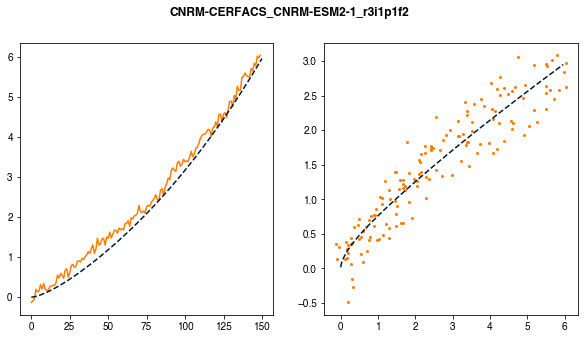

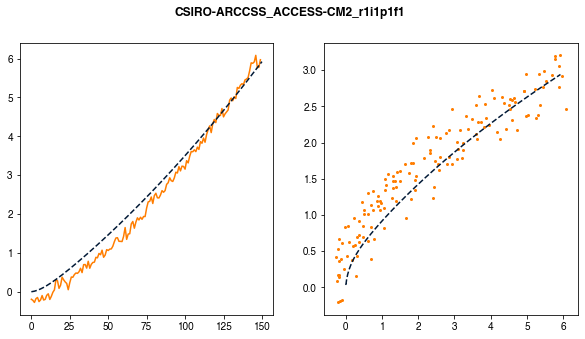

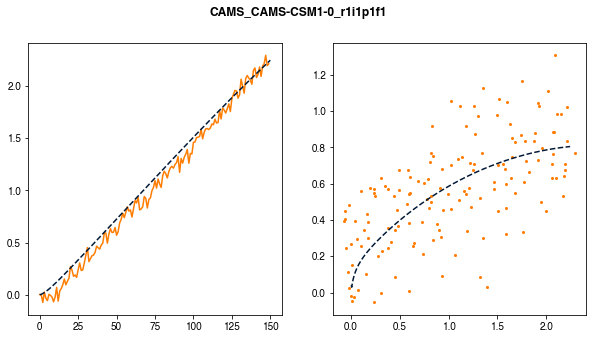

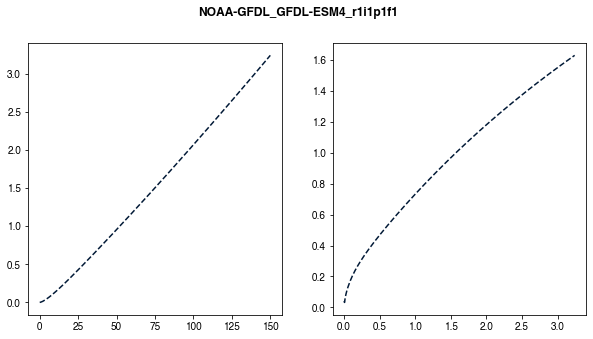

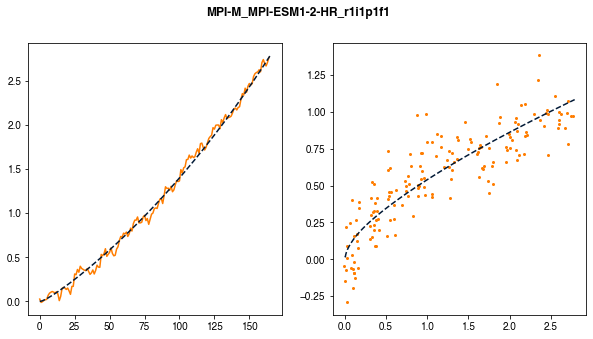

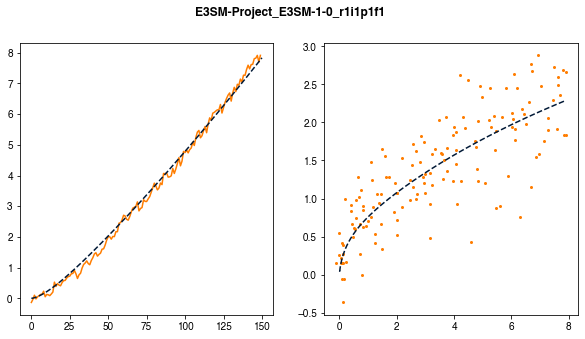

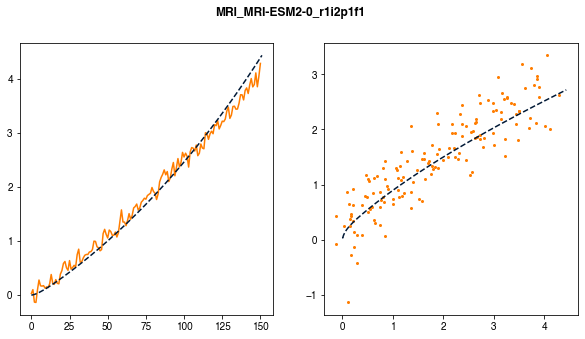

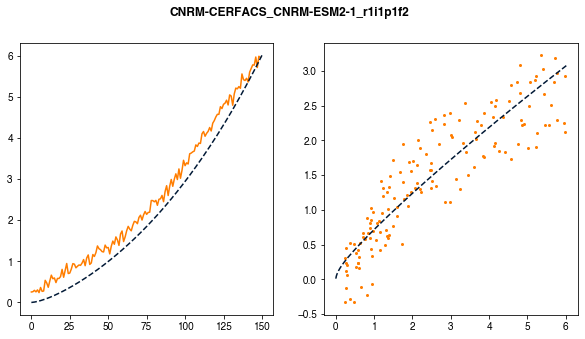

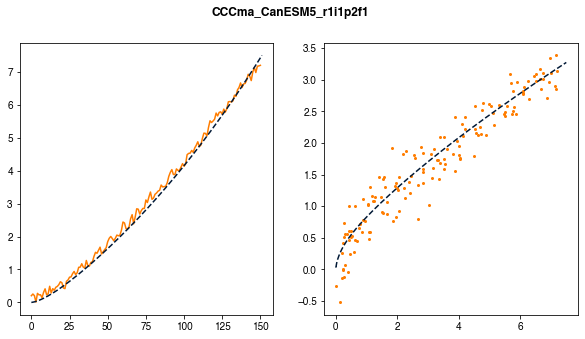

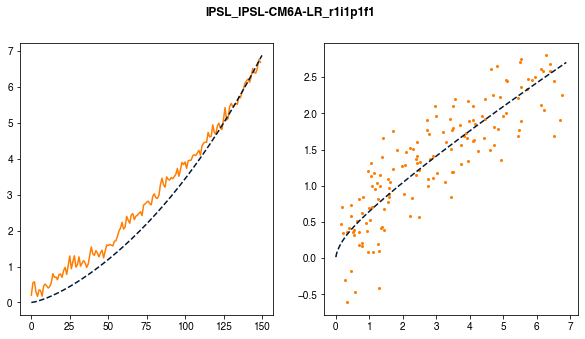

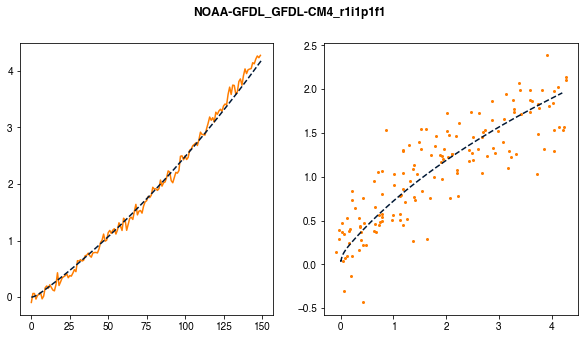

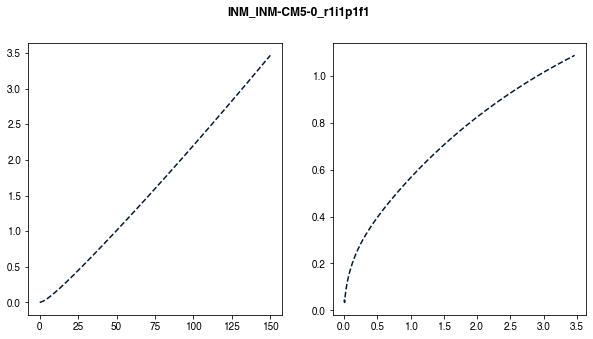

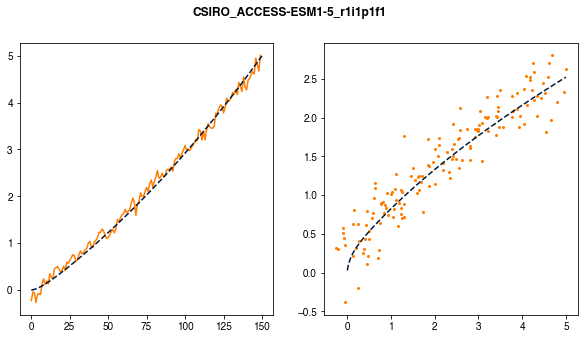

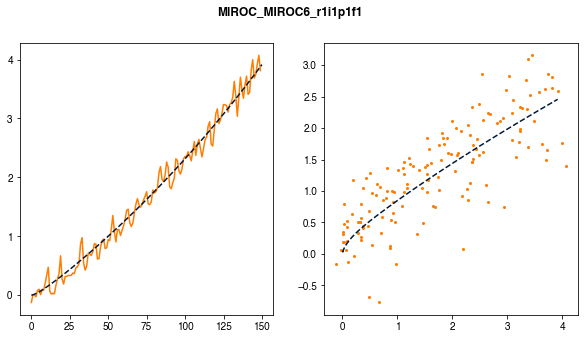

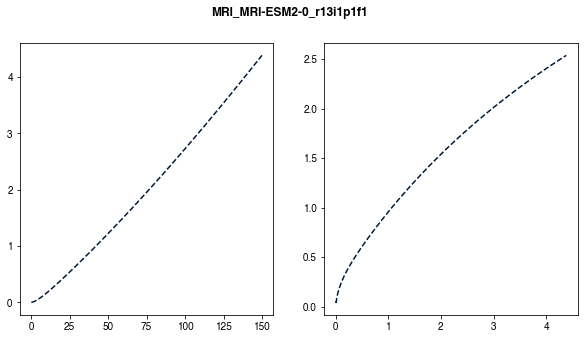

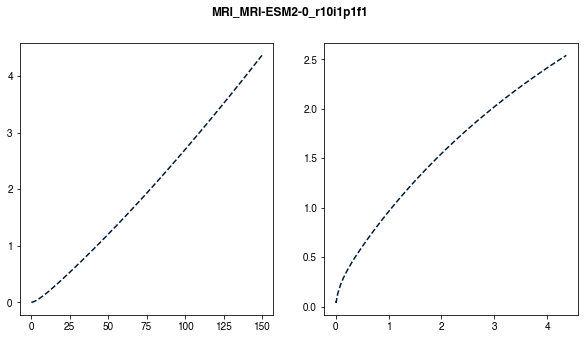

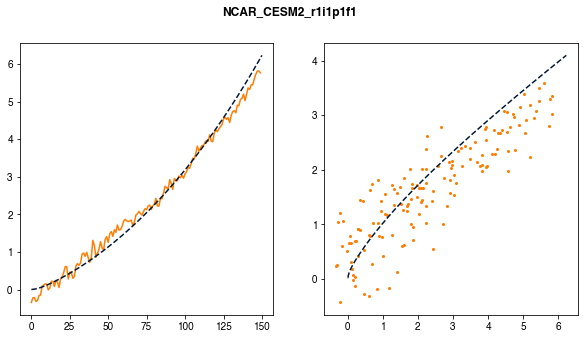

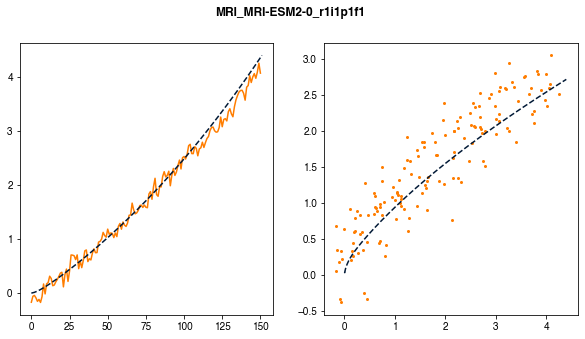

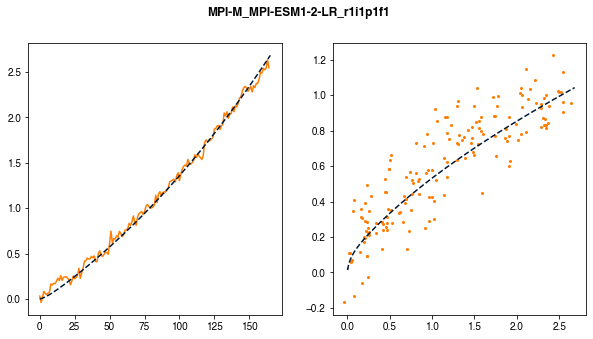

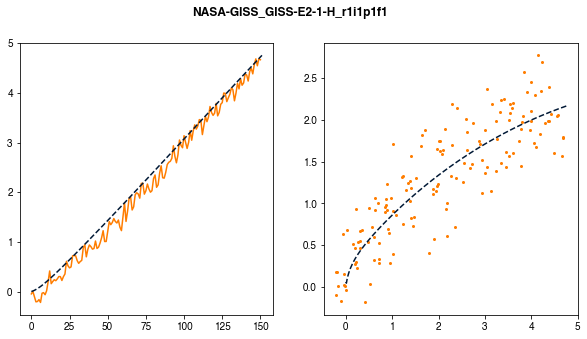

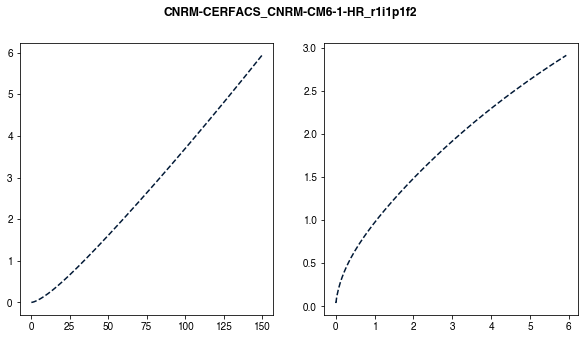

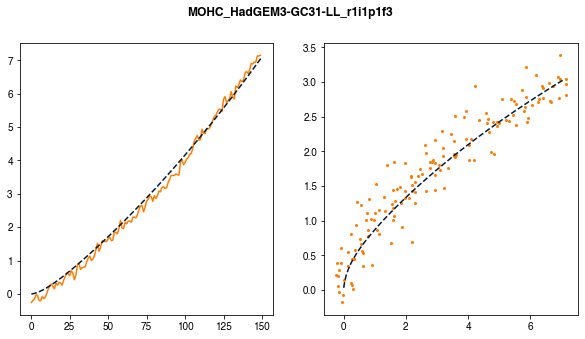

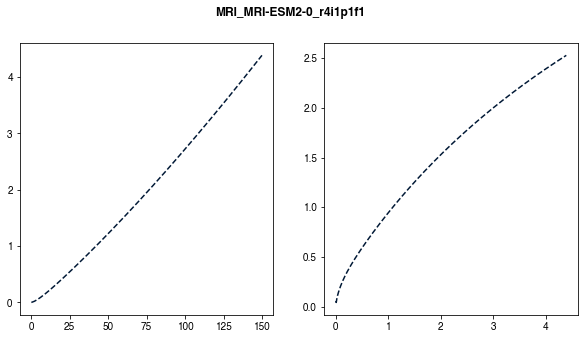

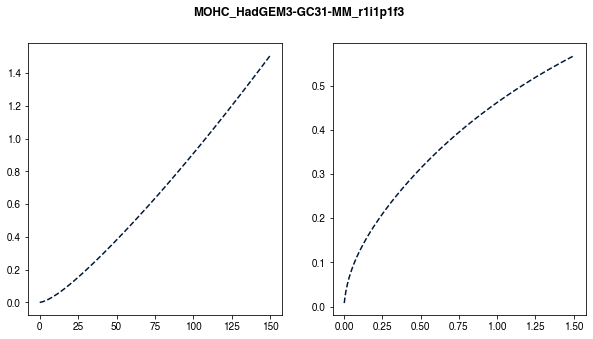

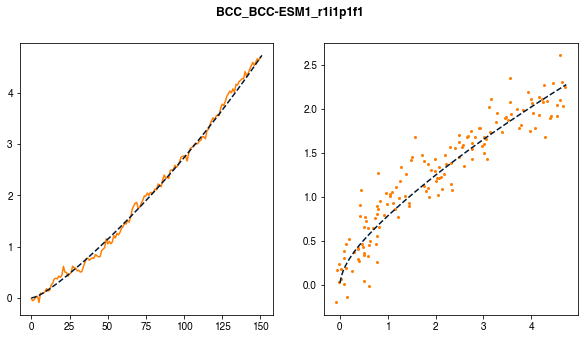

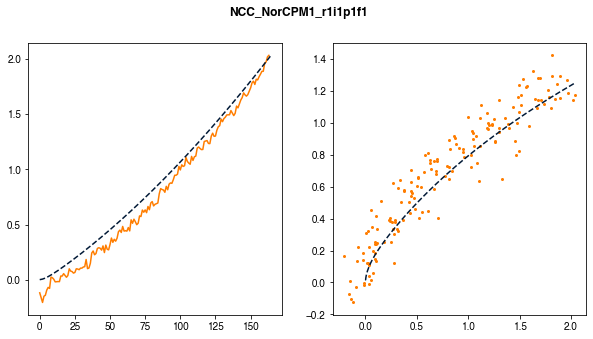

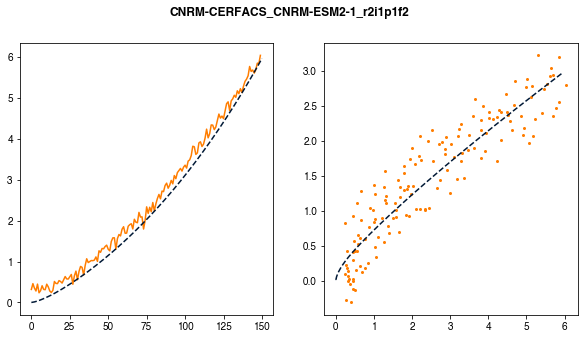

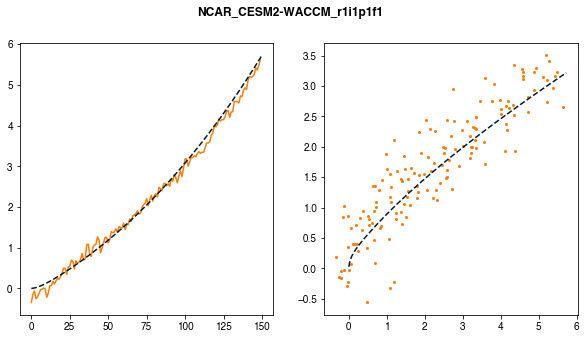

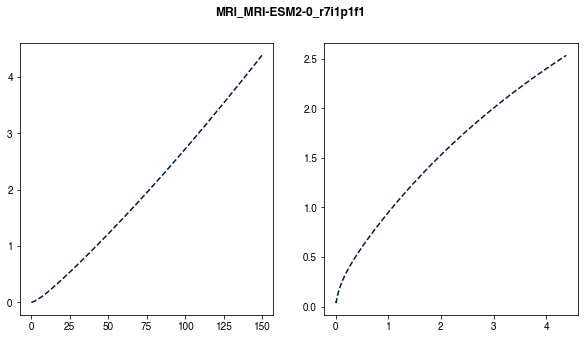

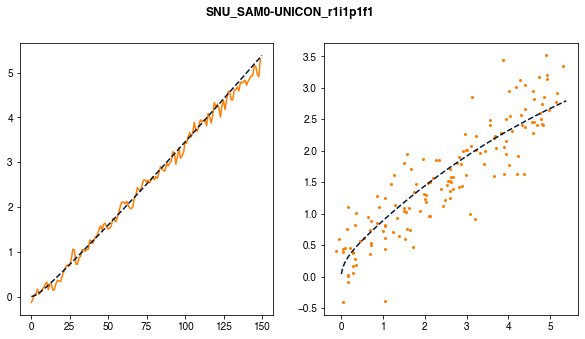

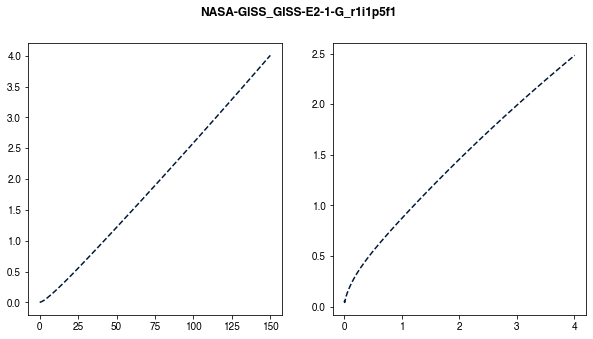

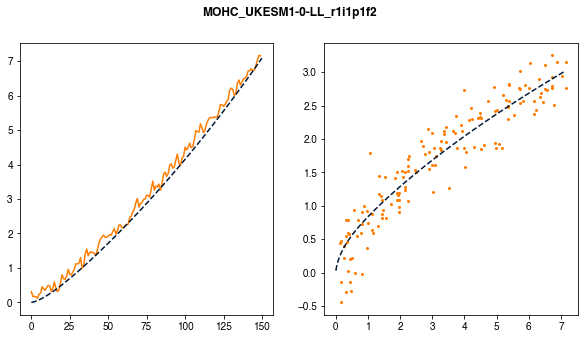

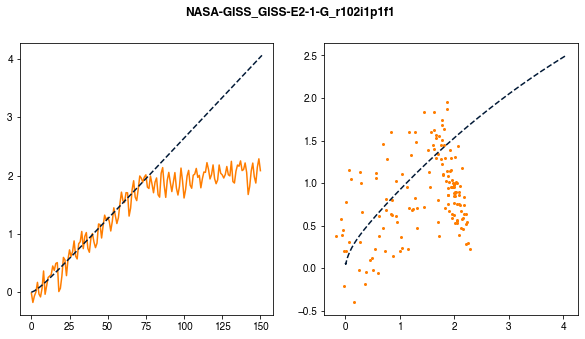

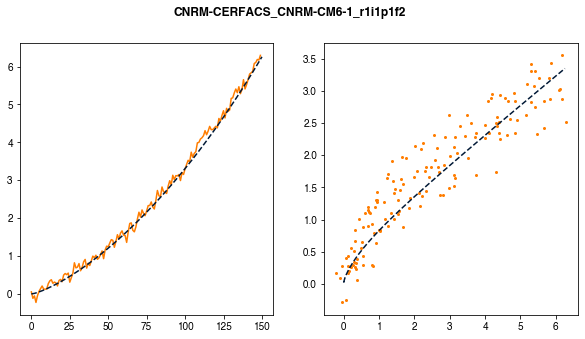

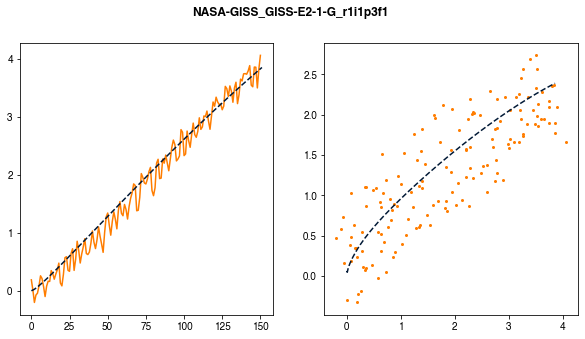

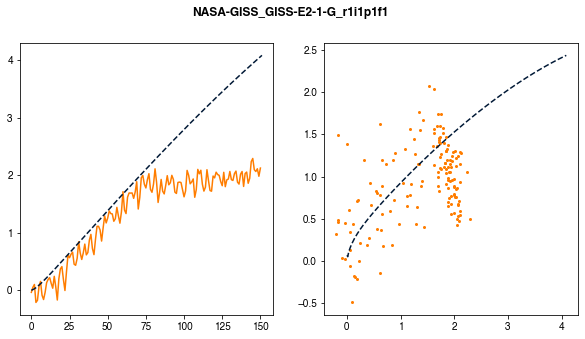

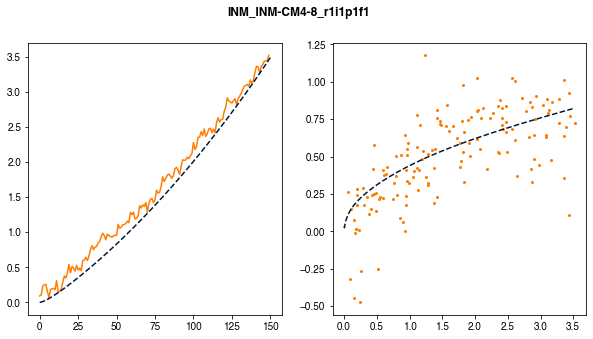

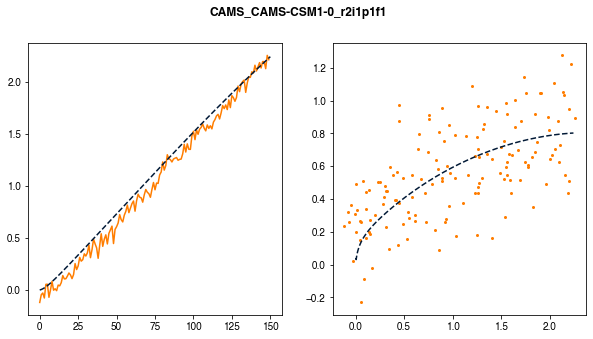

In [205]:
for ism in res_df.columns:
    result = check_F2x(ism)
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(result[0][0],ls='--')
    ax[1].plot(result[0][0],result[0][1],ls='--')
    if not result[1] is None:
        ax[0].plot(result[1][0],zorder=0)
        ax[1].plot(result[1][0],result[1][1],'o',ms=2,zorder=0)
    fig.suptitle(ism,fontweight='bold')

In [165]:
## diagnose TCR and ECS

In [206]:
def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

In [241]:
res_df.loc['ECS'] = np.nan
res_df.loc['TCR'] = np.nan
for model in res_df.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(res_df.loc[:'F_4x',model].values)],axis=1,keys=[model])
    res_df.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = res_df.loc['F_2x',model]).iloc[:,0]
res_df.loc['RWF'] = res_df.loc['TCR'] / res_df.loc['ECS']

(0.0, 3.0)

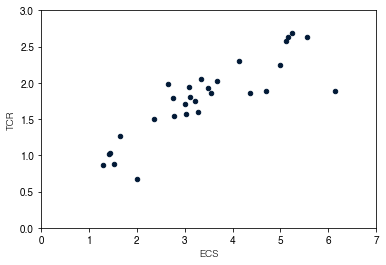

In [242]:
res_df.loc[['ECS','TCR']].T.plot.scatter('ECS','TCR')
plt.xlim(0,7)
plt.ylim(0,3)

In [279]:
indep_model_list = ['CCCma_CanESM5_r1i1p1f1', 
       'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1', 'CAMS_CAMS-CSM1-0_r1i1p1f1',
       'NOAA-GFDL_GFDL-ESM4_r1i1p1f1', 'MPI-M_MPI-ESM1-2-HR_r1i1p1f1',
       'E3SM-Project_E3SM-1-0_r1i1p1f1',
       'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
       'IPSL_IPSL-CM6A-LR_r1i1p1f1', 'NOAA-GFDL_GFDL-CM4_r1i1p1f1',
       'INM_INM-CM5-0_r1i1p1f1', 'CSIRO_ACCESS-ESM1-5_r1i1p1f1',
       'MIROC_MIROC6_r1i1p1f1', 'NCAR_CESM2_r1i1p1f1',
       'MRI_MRI-ESM2-0_r1i1p1f1', 'MPI-M_MPI-ESM1-2-LR_r1i1p1f1',
       'NASA-GISS_GISS-E2-1-H_r1i1p1f1', 'CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2',
       'MOHC_HadGEM3-GC31-LL_r1i1p1f3',
       'MOHC_HadGEM3-GC31-MM_r1i1p1f3', 'BCC_BCC-ESM1_r1i1p1f1',
       'NCC_NorCPM1_r1i1p1f1', 
       'NCAR_CESM2-WACCM_r1i1p1f1', 
       'SNU_SAM0-UNICON_r1i1p1f1', 
       'MOHC_UKESM1-0-LL_r1i1p1f2', 
       'CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2',
       'NASA-GISS_GISS-E2-1-G_r1i1p1f1', 'INM_INM-CM4-8_r1i1p1f1']

In [368]:
no_outlier_model_list = ['CCCma_CanESM5_r1i1p1f1', 
       'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1', 'CAMS_CAMS-CSM1-0_r1i1p1f1',
       'NOAA-GFDL_GFDL-ESM4_r1i1p1f1', 'MPI-M_MPI-ESM1-2-HR_r1i1p1f1',
       'E3SM-Project_E3SM-1-0_r1i1p1f1',
       'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
       'IPSL_IPSL-CM6A-LR_r1i1p1f1',
       'INM_INM-CM5-0_r1i1p1f1', 'CSIRO_ACCESS-ESM1-5_r1i1p1f1',
       'MRI_MRI-ESM2-0_r1i1p1f1', 'MPI-M_MPI-ESM1-2-LR_r1i1p1f1',
       'NASA-GISS_GISS-E2-1-H_r1i1p1f1', 'CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2',
       'MOHC_HadGEM3-GC31-LL_r1i1p1f3',
       'MOHC_HadGEM3-GC31-MM_r1i1p1f3', 'BCC_BCC-ESM1_r1i1p1f1',
       'NCC_NorCPM1_r1i1p1f1', 
       'SNU_SAM0-UNICON_r1i1p1f1', 
       'MOHC_UKESM1-0-LL_r1i1p1f2', 
       'NASA-GISS_GISS-E2-1-G_r1i1p1f1', 'INM_INM-CM4-8_r1i1p1f1']

In [369]:
fair_param_df = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in res_df.iteritems()],axis=1,keys=res_df.columns)[no_outlier_model_list]#.reindex([no_outlier_model_list],axis=1)

fair_params_stats = pd.DataFrame(fair_param_df.unstack().reset_index().set_index(['level_2','level_1','level_0']).unstack(2)[0].T.reset_index().values,columns=['model','d1','d2','d3','q1','q2','q3']).set_index('model').apply(pd.to_numeric)

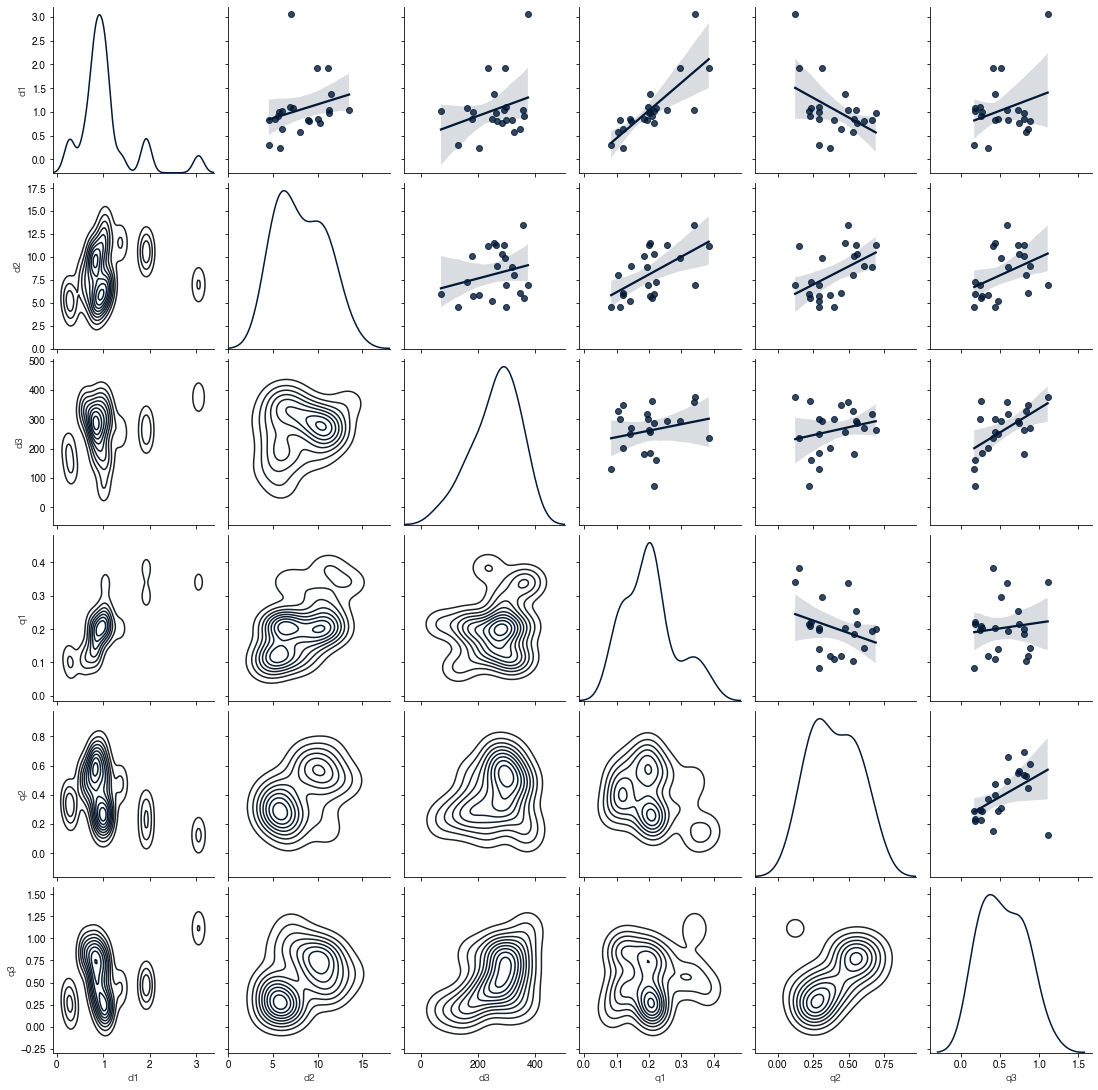

In [370]:
# pairplot = sn.pairplot(pd.DataFrame(fair_param_df.unstack().reset_index().set_index(['level_2','level_1','level_0']).unstack(2)[0].T.reset_index().values,columns=['model','d1','d2','d3','q1','q2','q3']),corner=True,kind='scatter',diag_kind='hist',diag_kws={"bins": 30})

g = sn.PairGrid(fair_params_stats,diag_sharey=False)

g = g.map_upper(sn.regplot)
g = g.map_diag(sn.kdeplot)
g = g.map_lower(sn.kdeplot)
# [a.set(xscale='log',yscale='log') for a in pairplot.axes.flatten() if a is not None]

<AxesSubplot:>

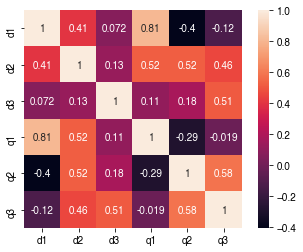

In [371]:
sn.heatmap(fair_params_stats.corr(method='spearman'),square=True,annot=True)

In [372]:
fair_params_stats.cov().values

array([[ 3.61964343e-01,  4.12161392e-01,  1.39956991e+01,
         3.80943593e-02, -4.57265276e-02,  4.68800435e-02],
       [ 4.12161392e-01,  7.05140407e+00,  5.23675036e+01,
         1.26045312e-01,  2.19537680e-01,  2.91806222e-01],
       [ 1.39956991e+01,  5.23675036e+01,  6.34183337e+03,
         1.43715561e+00,  2.96970497e+00,  1.22502826e+01],
       [ 3.80943593e-02,  1.26045312e-01,  1.43715561e+00,
         6.51046487e-03, -4.15900581e-03,  2.58438391e-03],
       [-4.57265276e-02,  2.19537680e-01,  2.96970497e+00,
        -4.15900581e-03,  2.75795314e-02,  2.28847040e-02],
       [ 4.68800435e-02,  2.91806222e-01,  1.22502826e+01,
         2.58438391e-03,  2.28847040e-02,  7.52248663e-02]])

In [373]:
fair_params_stats.mean().values

array([1.05060356e+00, 8.16552935e+00, 2.61864780e+02, 2.03596012e-01,
       3.98107002e-01, 5.45638414e-01])

In [374]:
fair_params_stats.describe(percentiles=[.003,.5,.997])

d1         d2          d3         q1         q2         q3
count  22.000000  22.000000   22.000000  22.000000  22.000000  22.000000
mean    1.050604   8.165529  261.864780   0.203596   0.398107   0.545638
std     0.601635   2.655448   79.635629   0.080687   0.166071   0.274272
min     0.245855   4.542276   71.052186   0.083432   0.124043   0.174227
0.3%    0.249755   4.544725   74.720692   0.084755   0.125913   0.174806
50%     0.935535   7.610096  277.278176   0.200511   0.385134   0.501116
99.7%   2.981435  13.410748  374.465665   0.381634   0.687910   1.100386
max     3.052388  13.536192  375.360088   0.384381   0.689751   1.114333

In [412]:
pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1).describe(percentiles=[.16,.5,.84])

d1         d2          d3         q1         q2         q3  \
count  22.000000  22.000000   22.000000  22.000000  22.000000  22.000000   
mean    1.050604   8.165529  261.864780   0.203596   0.398107   0.545638   
std     0.601635   2.655448   79.635629   0.080687   0.166071   0.274272   
min     0.245855   4.542276   71.052186   0.083432   0.124043   0.174227   
16%     0.683568   5.614229  181.608287   0.119104   0.228707   0.253359   
50%     0.935535   7.610096  277.278176   0.200511   0.385134   0.501116   
84%     1.280278  11.263729  340.021977   0.281075   0.557642   0.826698   
max     3.052388  13.536192  375.360088   0.384381   0.689751   1.114333   

           ln_d1        ECS        TCR        RWF  
count  22.000000  23.000000  23.000000  23.000000  
mean   -0.086420   3.557872   1.827382   0.544310  
std     0.542548   1.501353   0.620042   0.120037  
min    -1.403014   1.296993   0.679751   0.306546  
16%    -0.383909   1.833153   1.153286   0.436742  
50%    -0.067234   3.268272   1.880860   0.542036  
84%     0.242003   5.195573   2.461613   0.650214  
max     1.115924   6.145942   3.072691   0.772775

<AxesSubplot:>

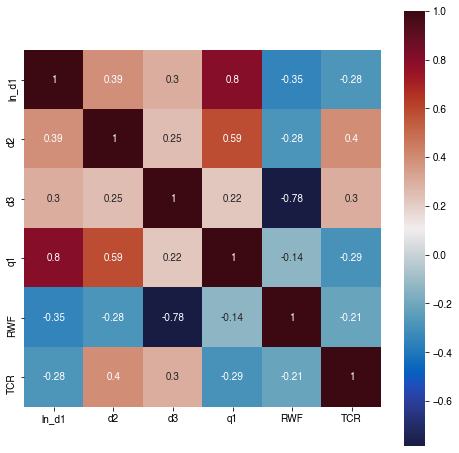

In [401]:
fig,ax = plt.subplots(figsize=(8,8))
sn.heatmap(pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1)[['ln_d1','d2','d3','q1','RWF','TCR']].corr(),ax=ax,square=True,annot=True,cmap=cmocean.cm.balance)

In [406]:
pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1)[['ln_d1','d2','q1']].cov().values

array([[2.94358445e-01, 5.58963469e-01, 3.49480987e-02],
       [5.58963469e-01, 7.05140407e+00, 1.26045312e-01],
       [3.49480987e-02, 1.26045312e-01, 6.51046487e-03]])

In [407]:
pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1)[['ln_d1','d2','q1']].mean().values

array([-0.08642002,  8.16552935,  0.20359601])

In [410]:
pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1)[['RWF','d3']].cov().values

array([[ 1.44088893e-02, -6.69645898e+00],
       [-6.69645898e+00,  6.34183337e+03]])

In [408]:
pd.concat([fair_params_stats,res_df.loc[['ECS','TCR','RWF'],indep_model_list].T],axis=1)[['RWF','d3']].mean().values

array([  0.54430983, 261.86477998])

### Logged d1_parameter

In [375]:
fair_params_stats['ln_d1'] = np.log(fair_params_stats['d1'])

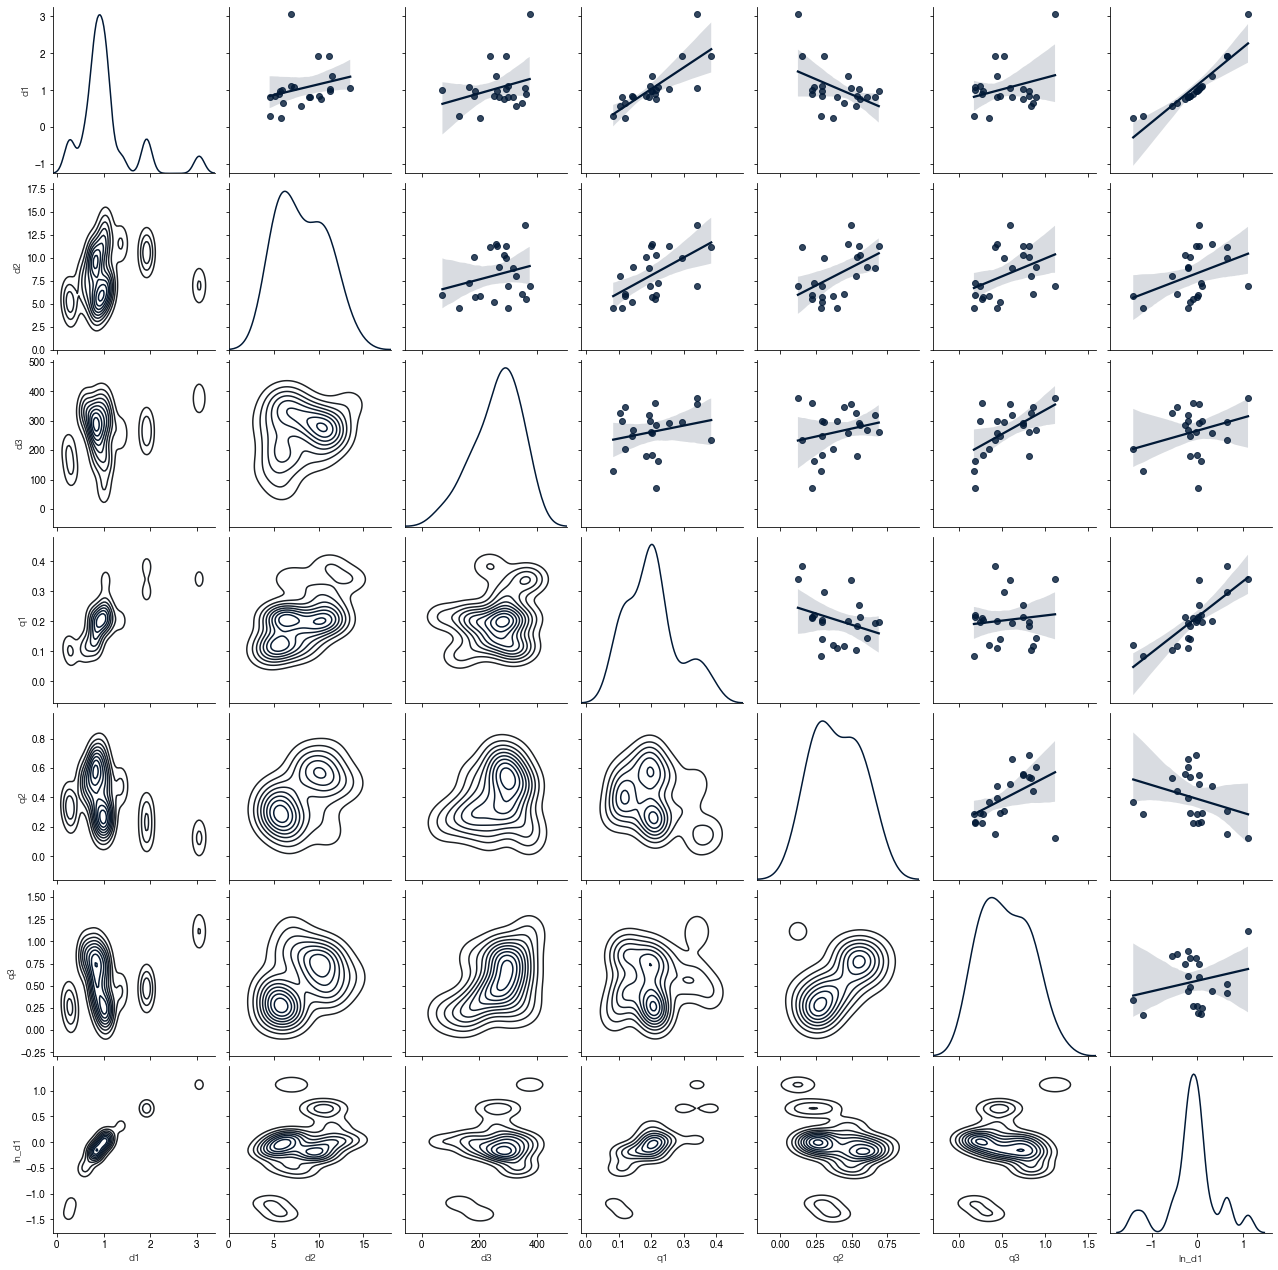

In [376]:
# pairplot = sn.pairplot(pd.DataFrame(fair_param_df.unstack().reset_index().set_index(['level_2','level_1','level_0']).unstack(2)[0].T.reset_index().values,columns=['model','d1','d2','d3','q1','q2','q3']),corner=True,kind='scatter',diag_kind='hist',diag_kws={"bins": 30})

g = sn.PairGrid(fair_params_stats,diag_sharey=False)

g = g.map_upper(sn.regplot)
g = g.map_diag(sn.kdeplot)
g = g.map_lower(sn.kdeplot)
# [a.set(xscale='log',yscale='log') for a in pairplot.axes.flatten() if a is not None]

<AxesSubplot:>

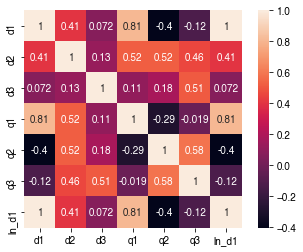

In [377]:
sn.heatmap(fair_params_stats.corr(method='spearman'),square=True,annot=True)

In [378]:
fair_params_stats[['ln_d1','d2','d3','q1','q2','q3']].cov().values

array([[ 2.94358445e-01,  5.58963469e-01,  1.29338443e+01,
         3.49480987e-02, -2.77113736e-02,  3.50228561e-02],
       [ 5.58963469e-01,  7.05140407e+00,  5.23675036e+01,
         1.26045312e-01,  2.19537680e-01,  2.91806222e-01],
       [ 1.29338443e+01,  5.23675036e+01,  6.34183337e+03,
         1.43715561e+00,  2.96970497e+00,  1.22502826e+01],
       [ 3.49480987e-02,  1.26045312e-01,  1.43715561e+00,
         6.51046487e-03, -4.15900581e-03,  2.58438391e-03],
       [-2.77113736e-02,  2.19537680e-01,  2.96970497e+00,
        -4.15900581e-03,  2.75795314e-02,  2.28847040e-02],
       [ 3.50228561e-02,  2.91806222e-01,  1.22502826e+01,
         2.58438391e-03,  2.28847040e-02,  7.52248663e-02]])

In [379]:
fair_params_stats[['ln_d1','d2','d3','q1','q2','q3']].mean().values

array([-8.64200190e-02,  8.16552935e+00,  2.61864780e+02,  2.03596012e-01,
        3.98107002e-01,  5.45638414e-01])

### ECS and TCR statistics

In [359]:
res_df.loc[['ECS','TCR','RWF'],indep_model_list].quantile([0.05,0.5,0.95],axis=1)

ECS       TCR       RWF
0.05  1.433333  0.868020  0.345146
0.50  3.268272  1.880860  0.542036
0.95  5.949492  2.688065  0.745973

In [381]:
res_df.loc[['ECS','TCR','RWF'],indep_model_list].T.corr()

ECS       TCR       RWF
ECS  1.000000  0.859803 -0.633494
TCR  0.859803  1.000000 -0.213769
RWF -0.633494 -0.213769  1.000000